# Paths and imports

In [59]:
# Cell 0. Case selection and paths (case-first layout)
from pathlib import Path

ROOT = Path("..").resolve()

CASE_ID  = "elephant_7_val_4"
CASE_DIR = ROOT / "data" / "cases" / CASE_ID 
assert CASE_DIR.exists(), f"Missing CASE_DIR: {CASE_DIR}"

CASE_JSONL      = CASE_DIR / "generated" / f"{CASE_ID}.jsonl"
OCCLUDED_PNG    = CASE_DIR / "occluded.png"
SHAPES_XY_NPZ   = CASE_DIR / "generated" / "shapes_xy.npz"
COMPLETIONS_DIR = CASE_DIR / "generated" / "completions"
GT_PNG = CASE_DIR / "gt.png"

for p in [CASE_JSONL, OCCLUDED_PNG, SHAPES_XY_NPZ, COMPLETIONS_DIR]:
    assert p.exists(), f"Missing: {p}"

OUT_DIR = ROOT / "results"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("CASE_DIR:", CASE_DIR)
print("OUT_DIR :", OUT_DIR)


CASE_DIR: /home/hschatzle/monte-carlo-selection/data/cases/elephant_7_val_4
OUT_DIR : /home/hschatzle/monte-carlo-selection/results


In [60]:
# Cell 1. Load class names (JSONL: one JSON object per line)
import json

CLASS_NAMES_JSONL = ROOT / "data" / "class_names.jsonl"
with CLASS_NAMES_JSONL.open("r", encoding="utf-8") as f:
    classes = [json.loads(line)["class_name"] for line in f if line.strip()]

print("Loaded class list:", len(classes))


Loaded class list: 54


In [61]:
# Cell 2. Load shapes_xy.npz and resolve completion PNG paths
import numpy as np

z = np.load(SHAPES_XY_NPZ, allow_pickle=True)
out_files_raw = z["out_files"].tolist()
polygons_xy   = z["polygons"]
matlab_1_indexed = bool(z["matlab_1_indexed"]) if "matlab_1_indexed" in z else False

def resolve_png_path(p: str) -> Path:
    pth = Path(p)
    if pth.exists():
        return pth
    return (COMPLETIONS_DIR / pth.name)

png_paths = [resolve_png_path(p) for p in out_files_raw]
N = len(png_paths)

missing = sum(1 for p in png_paths if not p.exists())
print("N completions:", N)
print("Missing PNGs :", missing)


N completions: 10000
Missing PNGs : 0


# Inference from ONNX

In [62]:
# Cell 3. ONNX session + preprocessing
import onnxruntime as ort
import numpy as np
from PIL import Image

ONNX_PATH = ROOT / "data" / "models" / "resnet50_geirhos_tl_with_feats.onnx"

sess = ort.InferenceSession(str(ONNX_PATH), providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

IMG_SIZE = 224

def preprocess_imagenet(img: Image.Image, size: int = 224) -> np.ndarray:
    if img.mode != "RGB":
        img = img.convert("RGB")
    img = img.resize((size, size), resample=Image.BILINEAR)
    x = (np.asarray(img).astype(np.float32) / 255.0)
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    x = (x - mean[None, None, :]) / std[None, None, :]
    x = np.transpose(x, (2, 0, 1))[None, ...]
    return x.astype(np.float32)

def infer_logits(path: Path) -> np.ndarray:
    img = Image.open(path)
    x = preprocess_imagenet(img, IMG_SIZE)
    y = sess.run([output_name], {input_name: x})[0]
    return np.asarray(y).reshape(-1)

def softmax(logits: np.ndarray) -> np.ndarray:
    z = logits - np.max(logits)
    e = np.exp(z)
    return e / (np.sum(e) + 1e-12)


In [63]:
# Cell 4. Baseline target selection from occluded image (Plan B uses same target logic as Plan A)
occ_logits = infer_logits(OCCLUDED_PNG)
occ_prob = softmax(occ_logits)

target_idx = int(np.argmax(occ_logits))
TARGET_CLASS = classes[target_idx]

occ_tlog = float(occ_logits[target_idx])
occ_tpr  = float(occ_prob[target_idx])

print("Target from occluded baseline:")
print("  TARGET_CLASS:", TARGET_CLASS)
print("  target_idx  :", target_idx)
print("  baseline logit:", occ_tlog)
print("  baseline prob :", occ_tpr)

top10 = np.argsort(-occ_logits)[:10]
print("\nTop-10 baseline classes:")
for r, j in enumerate(top10, start=1):
    print(f"  {r:02d}. {classes[int(j)]:>12s}  logit={float(occ_logits[j]): .4f}  prob={float(occ_prob[j]): .4f}")


Target from occluded baseline:
  TARGET_CLASS: elephant
  target_idx  : 21
  baseline logit: 7.087069988250732
  baseline prob : 0.6987596750259399

Top-10 baseline classes:
  01.     elephant  logit= 7.0871  prob= 0.6988
  02.        tiger  logit= 4.9305  prob= 0.0809
  03.         bear  logit= 4.8594  prob= 0.0753
  04.          fox  logit= 3.9008  prob= 0.0289
  05.         wolf  logit= 3.7395  prob= 0.0246
  06.       coyote  logit= 3.4259  prob= 0.0180
  07.     squirrel  logit= 2.6977  prob= 0.0087
  08.         goat  logit= 2.6970  prob= 0.0087
  09.       monkey  logit= 2.6068  prob= 0.0079
  10.         lion  logit= 2.5912  prob= 0.0078


# Parallel Scoring

In [64]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import numpy as np
from tqdm.auto import tqdm

N_WORKERS = 8

# Preallocate outputs
tlog = np.full(N, np.nan, dtype=np.float64)
tpr  = np.full(N, np.nan, dtype=np.float64)
tmar = np.full(N, np.nan, dtype=np.float64)
tdel = np.full(N, np.nan, dtype=np.float64)

# Make plain strings for pickling
png_paths_str = [str(p) for p in png_paths]

def _score_chunk(chunk):
    """
    chunk: list of (i, path_str)
    Returns: (idxs, tlog_vals, tpr_vals, tmar_vals, tdel_vals)
    """
    # IMPORTANT: create per-process session here if infer_logits depends on global session.
    # If infer_logits already lazy-inits a session per process, you can omit this.

    idxs = []
    v_tlog = []
    v_tpr  = []
    v_tmar = []
    v_tdel = []

    for i, pstr in chunk:
        # avoid Path dependency in workers
        try:
            # quick existence check
            # using os.path.exists avoids Path pickle concerns
            import os
            if not os.path.exists(pstr):
                continue

            logits = infer_logits(pstr)          # ensure infer_logits accepts str path. if not, wrap Path(pstr)
            prob = softmax(logits)

            tl = float(logits[target_idx])
            other_max = float(np.max(np.delete(logits, target_idx)))

            idxs.append(i)
            v_tlog.append(tl)
            v_tpr.append(float(prob[target_idx]))
            v_tdel.append(float(tl - occ_tlog))
            v_tmar.append(float(tl - other_max))
        except Exception:
            # keep silent per-item failure (or collect errors if you prefer)
            continue

    return (
        np.asarray(idxs, dtype=np.int64),
        np.asarray(v_tlog, dtype=np.float64),
        np.asarray(v_tpr, dtype=np.float64),
        np.asarray(v_tmar, dtype=np.float64),
        np.asarray(v_tdel, dtype=np.float64),
    )

# Build chunks
pairs = [(i, png_paths_str[i]) for i in range(N)]
chunk_size = max(1, len(pairs) // (N_WORKERS * 8))  # small-ish chunks for load balancing
chunks = [pairs[j:j+chunk_size] for j in range(0, len(pairs), chunk_size)]

# Run
with ProcessPoolExecutor(max_workers=N_WORKERS) as ex:
    futs = [ex.submit(_score_chunk, ch) for ch in chunks]
    for fut in tqdm(as_completed(futs), total=len(futs)):
        idxs, a, b, c, d = fut.result()
        tlog[idxs] = a
        tpr[idxs]  = b
        tmar[idxs] = c
        tdel[idxs] = d

print("Scored completions. Finite:", int(np.isfinite(tlog).sum()), "/", N)


  0%|          | 0/65 [00:00<?, ?it/s]

Scored completions. Finite: 10000 / 10000


# Choosing Subset based on scores

In [65]:
# Cell 6 (REVISED). Eligible set E = all valid samples (no baseline-improvement filter)
import numpy as np

N_total = len(png_paths)

# Start with "has a score" criterion
E = np.isfinite(tlog)

# Optional: also require valid polygon if you have that flag
# (only do this if valid_poly exists and is aligned with global indices)
if "valid_poly" in globals():
    valid_poly_arr = np.asarray(valid_poly, dtype=bool)
    if valid_poly_arr.shape[0] == N_total:
        E = E & valid_poly_arr
    else:
        print("Warning: valid_poly exists but length != N_total. Skipping valid_poly filter.")

E_idx = np.where(E)[0].astype(int)

print("Eligible set size (all finite logits):", len(E_idx), "/", N_total)


Eligible set size (all finite logits): 10000 / 10000


# Building Penultimate Layer (Parallelized)

In [66]:
# Cell 7 (REVISED). Build penultimate-layer embeddings with ONNXRuntime
# Replaces "logits as embeddings" with features from the penultimate layer.
#
# You MUST set PENULT_OUT_NAME to the correct ONNX output name for the penultimate tensor.
# Run the "inspect outputs" cell below once to find it.

import numpy as np
import onnxruntime as ort
from pathlib import Path
from PIL import Image

# --- paths / model ---

so = ort.SessionOptions()
so.intra_op_num_threads = 8
so.inter_op_num_threads = 1  # good default for single-stream inference

SESSION = ort.InferenceSession(
    str(ONNX_PATH),
    sess_options=so,
    providers=["CPUExecutionProvider"],
)

# Find input name
IN_NAME = SESSION.get_inputs()[0].name

# Set this after inspecting outputs (next cell).
PENULT_OUT_NAME = "features"  # e.g. "avgpool" or "features" or similar
LOGITS_OUT_NAME = "output"  # optional, if model has logits output too

# --- preprocessing: adjust if your pipeline differs ---
IM_SIZE = 224
MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess_png(p: str | Path) -> np.ndarray:
    img = Image.open(p).convert("RGB").resize((IM_SIZE, IM_SIZE), resample=Image.BILINEAR)
    x = np.asarray(img, dtype=np.float32) / 255.0
    x = (x - MEAN[None, None, :]) / STD[None, None, :]
    x = np.transpose(x, (2, 0, 1))[None, ...]  # (1,3,224,224)
    return x.astype(np.float32, copy=False)

def infer_penult_and_logits(p: str | Path):
    x = preprocess_png(p)
    outs = [PENULT_OUT_NAME] + ([LOGITS_OUT_NAME] if LOGITS_OUT_NAME else [])
    y = SESSION.run(outs, {IN_NAME: x})
    pen = y[0]
    log = y[1] if LOGITS_OUT_NAME else None
    return pen, log

# --- build embedding matrix X from penultimate layer ---
if PENULT_OUT_NAME is None:
    raise RuntimeError("Set PENULT_OUT_NAME first. Run the output-inspection cell to find the right name.")

# We'll infer one item to get feature dimension
pen0, _ = infer_penult_and_logits(png_paths[int(E_idx[0])])
pen0 = np.asarray(pen0)
X_dim = int(np.prod(pen0.shape[1:]))  # flatten all but batch
X = np.zeros((len(E_idx), X_dim), dtype=np.float32)

for j, i in enumerate(E_idx):
    pen, _ = infer_penult_and_logits(png_paths[int(i)])
    pen = np.asarray(pen, dtype=np.float32)
    X[j] = pen.reshape(-1).astype(np.float32, copy=False)

# L2 normalize
norm = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
Xn = X / norm

print("Penultimate embedding matrix Xn:", Xn.shape)


Penultimate embedding matrix Xn: (10000, 2048)


In [67]:
# Cell 7b (OPTIONAL). Cache embeddings + aligned indices so you never recompute ONNX
import numpy as np
from pathlib import Path

CACHE_DIR = Path(CASE_DIR) / "cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

emb_path = CACHE_DIR / "penult_Xn.npy"
idx_path = CACHE_DIR / "E_idx.npy"

np.save(emb_path, Xn.astype(np.float32, copy=False))
np.save(idx_path, np.asarray(E_idx, dtype=np.int32))

print("Saved:", emb_path)
print("Saved:", idx_path)


Saved: /home/hschatzle/monte-carlo-selection/data/cases/elephant_7_val_4/cache/penult_Xn.npy
Saved: /home/hschatzle/monte-carlo-selection/data/cases/elephant_7_val_4/cache/E_idx.npy


In [68]:
# Cell 8. PCA denoise / compress (run this right after Xn exists)
import numpy as np
from sklearn.decomposition import PCA

PCA_D = 30  # 15-50 typical
pca = PCA(n_components=int(PCA_D), random_state=0)
Z = pca.fit_transform(Xn)

evr = pca.explained_variance_ratio_
print("Z:", Z.shape)
print("Explained variance first 10:", np.round(evr[:10], 4))
print("Cumulative EV:", float(evr.sum()))


Z: (10000, 30)
Explained variance first 10: [0.4646 0.1188 0.0697 0.0493 0.0334 0.0256 0.0227 0.0187 0.0175 0.015 ]
Cumulative EV: 0.9367055296897888


# Clustering

In [69]:
# Cell 9 (REVISED). Cluster into hypotheses using BayesianGaussianMixture (more stable defaults)
import numpy as np
from sklearn.mixture import BayesianGaussianMixture

K_MAX = 80
bgmm = BayesianGaussianMixture(
    n_components=int(K_MAX),
    covariance_type="diag",  # <<< change: more stable + faster
    weight_concentration_prior_type="dirichlet_process",
    weight_concentration_prior=1e-2,
    max_iter=2000,
    random_state=0,
    init_params="kmeans",
    reg_covar=1e-6,          # <<< change: avoid singular covariances
)
bgmm.fit(Z)

resp = bgmm.predict_proba(Z)  # (|E|, K_MAX)
mix_w = np.asarray(bgmm.weights_, dtype=np.float64)

# <<< change: use a smaller threshold to define "active"
ACTIVE_THR = 1e-4
active = np.where(mix_w > ACTIVE_THR)[0]

print("Active components:", len(active), "/", K_MAX, " (thr=", ACTIVE_THR, ")")
print("Top 10 mixture weights:", np.round(np.sort(mix_w)[::-1][:10], 6))


Active components: 48 / 80  (thr= 0.0001 )
Top 10 mixture weights: [0.117519 0.081765 0.069815 0.064195 0.042998 0.041687 0.034161 0.03398
 0.032014 0.031633]


# Debiasing

In [70]:
# Cell 9. Build occluder mask (pixel space) ONCE. from case.jsonl (recommended)
import json
import numpy as np
from pathlib import Path
from PIL import Image, ImageDraw

case_row = json.loads(CASE_JSONL.read_text(encoding="utf-8").splitlines()[-1])

occ_u = np.asarray(case_row["occluder_rect_xy"], dtype=np.float64)
bounds = case_row["shape_bounds"]
min_u = np.asarray(bounds["min"], dtype=np.float64)
max_u = np.asarray(bounds["max"], dtype=np.float64)

W_img, H_img = Image.open(OCCLUDED_PNG).size

def unit_to_pixel_affine(u_xy: np.ndarray) -> np.ndarray:
    u = np.asarray(u_xy, dtype=np.float64).reshape(-1, 2)
    x = (u[:, 0] - min_u[0]) / max(1e-12, (max_u[0] - min_u[0])) * (W_img - 1)
    y = (u[:, 1] - min_u[1]) / max(1e-12, (max_u[1] - min_u[1])) * (H_img - 1)
    return np.column_stack([x, y])

occluder_px = unit_to_pixel_affine(occ_u)

occ_mask_img = Image.new("L", (W_img, H_img), 0)
draw = ImageDraw.Draw(occ_mask_img)
draw.polygon([(float(x), float(y)) for x, y in occluder_px], outline=1, fill=1)
occluder_mask = (np.asarray(occ_mask_img, dtype=np.uint8) > 0)

occ_area_px = float(occluder_mask.sum() + 1e-12)

print("Occluder mask px:", int(occluder_mask.sum()))


Occluder mask px: 18715


In [72]:
# Cell 10 (PARALLEL, 8 cores). Recompute curvature aligned to E_idx (curv) for debiasing
import numpy as np
from shapely.geometry import Point, Polygon
from concurrent.futures import ProcessPoolExecutor, as_completed

occ_poly = Polygon(np.asarray(occluder_px, dtype=np.float64).tolist())

def turning_curvature(polyline_xy: np.ndarray, eps: float = 1e-12) -> float:
    x = np.asarray(polyline_xy, dtype=np.float64)
    if x.shape[0] < 3:
        return np.nan
    v1 = x[1:-1] - x[:-2]
    v2 = x[2:]   - x[1:-1]
    n1 = np.linalg.norm(v1, axis=1) + eps
    n2 = np.linalg.norm(v2, axis=1) + eps
    v1u = v1 / n1[:, None]
    v2u = v2 / n2[:, None]
    dot = np.clip(np.sum(v1u * v2u, axis=1), -1.0, 1.0)
    cross = v1u[:, 0] * v2u[:, 1] - v1u[:, 1] * v2u[:, 0]
    ang = np.arctan2(cross, dot)
    total_turn = np.sum(np.abs(ang))
    seg = x[1:] - x[:-1]
    arc_len = float(np.sum(np.linalg.norm(seg, axis=1)))
    return float(total_turn / (arc_len + eps))

def _points_inside_occluder_xy(xy: np.ndarray, occ_poly_wkb: bytes) -> np.ndarray:
    # Reconstruct polygon inside worker from WKB (picklable)
    from shapely import wkb
    from shapely.geometry import Point
    poly = wkb.loads(occ_poly_wkb)

    if xy.size == 0:
        return xy.reshape(0, 2)
    inside = []
    for p in xy:
        if poly.contains(Point(float(p[0]), float(p[1]))):
            inside.append(p)
    return np.asarray(inside, dtype=np.float64) if inside else np.zeros((0, 2), dtype=np.float64)

def _curv_one(args):
    # args = (j, i, poly_points, occ_poly_wkb, matlab_1_indexed_flag)
    j, i, pts, occ_poly_wkb, m1 = args
    pts = np.asarray(pts, dtype=np.float64).reshape(-1, 2)
    if m1:
        pts = pts - 1.0
    pts_in = _points_inside_occluder_xy(pts, occ_poly_wkb)
    if pts_in.shape[0] >= 3:
        c = turning_curvature(pts_in)
    else:
        c = turning_curvature(pts)
    return j, float(c)

# -------------------------
# Prepare tasks
# -------------------------
matlab_1_flag = bool(globals().get("matlab_1_indexed", False))
occ_wkb = occ_poly.wkb  # compact + picklable

tasks = []
for j, i in enumerate(E_idx):
    # send only what's needed per job: the polygon points for that index
    tasks.append((j, int(i), polygons_xy[int(i)], occ_wkb, matlab_1_flag))

curv = np.full((len(E_idx),), np.nan, dtype=np.float64)

# -------------------------
# Run with 8 processes
# -------------------------
N_WORKERS = 8
with ProcessPoolExecutor(max_workers=N_WORKERS) as ex:
    futs = [ex.submit(_curv_one, t) for t in tasks]
    for fut in as_completed(futs):
        j, c = fut.result()
        curv[j] = c

print("curv:", curv.shape, "finite:", int(np.isfinite(curv).sum()))


curv: (10000,) finite: 10000


In [73]:
# Cell 10 (PARALLEL, 8 cores). Binary masks from PNGs. compute fill_in_occ and fill_added_in_occ
import numpy as np
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed
from PIL import Image
from tqdm.auto import tqdm


def _png_to_shape_mask_from_path(p_str: str) -> np.ndarray:
    arr = np.asarray(Image.open(p_str).convert("L"), dtype=np.uint8)
    return arr < 128


def _worker_chunk(args):
    """
    Process a chunk of indices to reduce scheduling overhead.
    args = (chunk_j, chunk_i, png_paths_list, occluder_mask, baseline_mask)
    Returns (js, fill_in_occ_vals, fill_added_in_occ_vals)
    """
    js, idxs, png_paths, occluder_mask, baseline_mask = args

    fill1 = np.full((len(js),), np.nan, dtype=np.float64)
    fill2 = np.full((len(js),), np.nan, dtype=np.float64)

    for k, (j, i) in enumerate(zip(js, idxs)):
        p = png_paths[int(i)]
        if not p:
            continue
        if not Path(p).exists():
            continue

        m = _png_to_shape_mask_from_path(p)

        # total shape fraction inside occluder
        fill1[k] = float(m[occluder_mask].mean())

        # added shape fraction inside occluder vs baseline
        added = m & (~baseline_mask)
        fill2[k] = float(added[occluder_mask].mean())

    return js, fill1, fill2


# -------------------------
# Inputs
# -------------------------
baseline_mask = _png_to_shape_mask_from_path(str(OCCLUDED_PNG))

fill_in_occ = np.full((len(E_idx),), np.nan, dtype=np.float64)
fill_added_in_occ = np.full((len(E_idx),), np.nan, dtype=np.float64)

# Make sure png_paths are strings (picklable) and indexed by i
png_paths_str = [str(p) for p in png_paths]

# -------------------------
# Chunk the work
# -------------------------
N_WORKERS = 8
CHUNK_SIZE = 150  # tune 100-500. Larger reduces overhead, smaller balances better.

chunks = []
for start in range(0, len(E_idx), CHUNK_SIZE):
    stop = min(len(E_idx), start + CHUNK_SIZE)
    js = list(range(start, stop))
    idxs = [int(E_idx[j]) for j in js]
    chunks.append((js, idxs, png_paths_str, occluder_mask, baseline_mask))

# -------------------------
# Run in parallel
# -------------------------
with ProcessPoolExecutor(max_workers=N_WORKERS) as ex:
    futs = [ex.submit(_worker_chunk, c) for c in chunks]
    for fut in tqdm(as_completed(futs), total=len(futs)):
        js, fill1, fill2 = fut.result()
        fill_in_occ[js] = fill1
        fill_added_in_occ[js] = fill2

print("fill_in_occ stats min/mean/max =",
      float(np.nanmin(fill_in_occ)), float(np.nanmean(fill_in_occ)), float(np.nanmax(fill_in_occ)))
print("fill_added_in_occ stats min/mean/max =",
      float(np.nanmin(fill_added_in_occ)), float(np.nanmean(fill_added_in_occ)), float(np.nanmax(fill_added_in_occ)))

print("unique fill_in_occ (1e-4):", int(np.unique(np.round(fill_in_occ[np.isfinite(fill_in_occ)], 4)).size))
print("unique fill_added_in_occ (1e-4):", int(np.unique(np.round(fill_added_in_occ[np.isfinite(fill_added_in_occ)], 4)).size))


  0%|          | 0/67 [00:00<?, ?it/s]

fill_in_occ stats min/mean/max = 0.0 0.0 0.0
fill_added_in_occ stats min/mean/max = 0.0 0.0 0.0
unique fill_in_occ (1e-4): 1
unique fill_added_in_occ (1e-4): 1


In [74]:
# Cell 12 (REVISED). Stable debias weights: curvature × fill_in_occ (quantile bins + cap)
import numpy as np
import pandas as pd

size_metric = fill_in_occ  # <-- use total shape-vs-background inside occluder

curv_safe = np.asarray(curv, dtype=np.float64).copy()
curv_safe[~np.isfinite(curv_safe)] = float(np.nanmedian(curv_safe))

ok = np.isfinite(curv_safe) & np.isfinite(size_metric)
if int(ok.sum()) < 50:
    raise RuntimeError(f"Too few valid samples for debiasing: {int(ok.sum())}")

def invfreq_weights_quantile(x: np.ndarray, bins: int) -> np.ndarray:
    x = np.asarray(x, dtype=np.float64)
    # quantile bin edges to equalize counts
    qs = np.linspace(0.0, 1.0, int(bins) + 1)
    edges = np.quantile(x, qs)
    # avoid identical edges collapsing bins
    edges[0] -= 1e-12
    edges[-1] += 1e-12
    b = np.digitize(x, edges) - 1
    b = np.clip(b, 0, bins - 1)
    cnt = np.bincount(b, minlength=bins).astype(np.float64)
    p = cnt / (cnt.sum() + 1e-12)
    w = 1.0 / (p[b] + 1e-12)
    w = w / (w.mean() + 1e-12)
    return w

BINS_CURV = 20
BINS_SIZE = 20

w_curv = np.ones((len(E_idx),), dtype=np.float64)
w_size = np.ones((len(E_idx),), dtype=np.float64)

w_curv[ok] = invfreq_weights_quantile(curv_safe[ok], bins=BINS_CURV)
w_size[ok] = invfreq_weights_quantile(size_metric[ok], bins=BINS_SIZE)

w_joint = w_curv * w_size

# cap extreme weights (prevents a few samples dominating)
CAP = 10.0
w_joint[ok] = np.clip(w_joint[ok], 1.0 / CAP, CAP)

# renormalize to mean 1
w_joint[ok] = w_joint[ok] / (np.mean(w_joint[ok]) + 1e-12)

print("w_joint stats min/mean/max =", float(w_joint[ok].min()), float(w_joint[ok].mean()), float(w_joint[ok].max()))

# masses
mass_raw = resp.sum(axis=0)
mass_debias = (w_joint[:, None] * resp).sum(axis=0)

comp_df = pd.DataFrame({
    "k": np.arange(resp.shape[1], dtype=int),
    "mix_weight": mix_w,
    "mass_raw": mass_raw,
    "mass_debias": mass_debias,
})

active_df = comp_df.query("mix_weight > 1e-4").copy()
active_df = active_df.sort_values("mass_debias", ascending=False).reset_index(drop=True)

print("Active components:", active_df.shape[0], "/", resp.shape[1])
active_df.head(15)


w_joint stats min/mean/max = 0.9999999999990002 0.9999999999989999 0.9999999999990002
Active components: 48 / 80


,k,mix_weight,mass_raw,mass_debias
0,51,0.117519,1183.424096,1183.424096
1,18,0.081765,818.409889,818.409889
2,15,0.069815,698.374792,698.374792
3,75,0.064195,654.659292,654.659292
4,13,0.042998,429.627981,429.627981
5,62,0.041687,420.944928,420.944928
6,30,0.034161,341.973132,341.973132
7,49,0.033980,341.324748,341.324748
8,52,0.032014,321.740829,321.740829
9,32,0.031633,316.686802,316.686802


Top 10 k: [51, 18, 15, 75, 13, 62, 30, 49, 52, 32]
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 0.342s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.010592
[t-SNE] KL divergence after 250 iterations with early exaggeration: 287.848145
[t-SNE] KL divergence afte

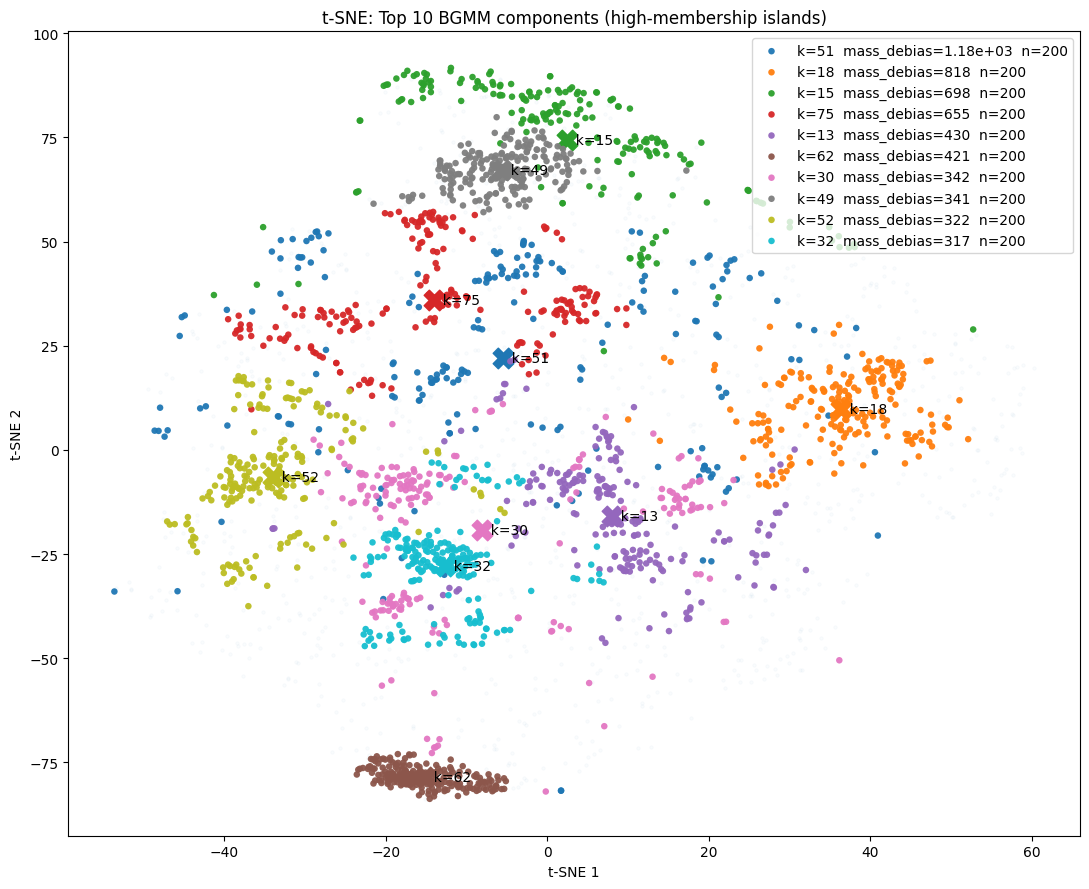

k=51: n=200  r_ik min/med/max = 0.999 / 1.000 / 1.000
k=18: n=200  r_ik min/med/max = 1.000 / 1.000 / 1.000
k=15: n=200  r_ik min/med/max = 1.000 / 1.000 / 1.000
k=75: n=200  r_ik min/med/max = 0.997 / 1.000 / 1.000
k=13: n=200  r_ik min/med/max = 0.987 / 0.999 / 1.000
k=62: n=200  r_ik min/med/max = 1.000 / 1.000 / 1.000
k=30: n=200  r_ik min/med/max = 0.976 / 0.999 / 1.000
k=49: n=200  r_ik min/med/max = 0.977 / 0.999 / 1.000
k=52: n=200  r_ik min/med/max = 0.977 / 1.000 / 1.000
k=32: n=200  r_ik min/med/max = 0.984 / 1.000 / 1.000


In [75]:
# Cell X (CLEAN TOP-10). t-SNE showing only strongest BGMM components as compact islands

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

Z = np.asarray(Z, dtype=np.float64)
resp = np.asarray(resp, dtype=np.float64)
nE, d = Z.shape

# ---------- choose top 10 components ----------
df = active_df.sort_values("mass_debias", ascending=False).reset_index(drop=True)
top_ks = [int(k) for k in df.head(10)["k"].values]

print("Top 10 k:", top_ks)

# ---------- embed (t-SNE) ----------
perplexity = 80
tsne = TSNE(
    n_components=2,
    perplexity=min(perplexity, (nE - 1) // 3),
    init="random",
    random_state=0,
    early_exaggeration=36.0,
    learning_rate="auto",
    max_iter=3000,
    verbose=1,
)
Y = tsne.fit_transform(Z)

# ---------- CLEAN membership selection ----------
TAU = 0.8
MAX_PER = 200
MIN_PER = 40
FALLBACK_TOPN = 150

picked = {}
picked_r = {}
centroid = {}

for k in top_ks:
    rik = resp[:, k].astype(np.float64)
    ok = np.isfinite(rik)
    idx = np.where(ok)[0]
    if idx.size == 0:
        picked[k] = np.array([], dtype=int)
        continue

    sel = idx[rik[idx] >= TAU]

    if sel.size < MIN_PER:
        order = idx[np.argsort(rik[idx])[::-1]]
        sel = order[:min(FALLBACK_TOPN, order.size)]

    if sel.size > MAX_PER:
        order = sel[np.argsort(rik[sel])[::-1]]
        sel = order[:MAX_PER]

    picked[k] = sel
    picked_r[k] = rik[sel]
    centroid[k] = (float(np.mean(Y[sel, 0])), float(np.mean(Y[sel, 1])))

# ---------- plotting ----------
cmap = plt.get_cmap("tab10")
color_for_k = {k: cmap(i % 10) for i, k in enumerate(top_ks)}

rng = np.random.default_rng(0)

# faint background subsample
BG_N = 1200
bg_idx = rng.choice(np.arange(nE), size=min(BG_N, nE), replace=False)

plt.figure(figsize=(11, 9))
plt.scatter(Y[bg_idx, 0], Y[bg_idx, 1], s=6, alpha=0.02)

handles, labels = [], []

for k in top_ks:
    sel = picked[k]
    if sel.size == 0:
        continue

    col = color_for_k[k]
    mass = float(df.loc[df["k"] == k, "mass_debias"].values[0])

    sc = plt.scatter(
        Y[sel, 0], Y[sel, 1],
        s=22,
        alpha=0.95,
        color=col,
        edgecolors="none",
    )

    # centroid marker
    cx, cy = centroid[k]
    plt.scatter([cx], [cy], s=220, marker="X", color=col, alpha=1.0)
    plt.text(cx, cy, f"  k={k}", fontsize=10, va="center")

    handles.append(sc)
    labels.append(f"k={k}  mass_debias={mass:.3g}  n={sel.size}")

plt.title("t-SNE: Top 10 BGMM components (high-membership islands)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(handles, labels, loc="best", frameon=True)
plt.tight_layout()
plt.show()

# ---------- membership quality ----------
for k in top_ks:
    r = picked_r[k]
    print(
        f"k={k}: n={picked[k].size}  "
        f"r_ik min/med/max = {float(r.min()):.3f} / {float(np.median(r)):.3f} / {float(r.max()):.3f}"
    )




Illustrative components: [3, 11, 49, 54, 38]
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 0.185s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.010718
[t-SNE] KL divergence after 250 iterations with early exaggeration: 287.952698
[t-SNE] KL divergence after 3000

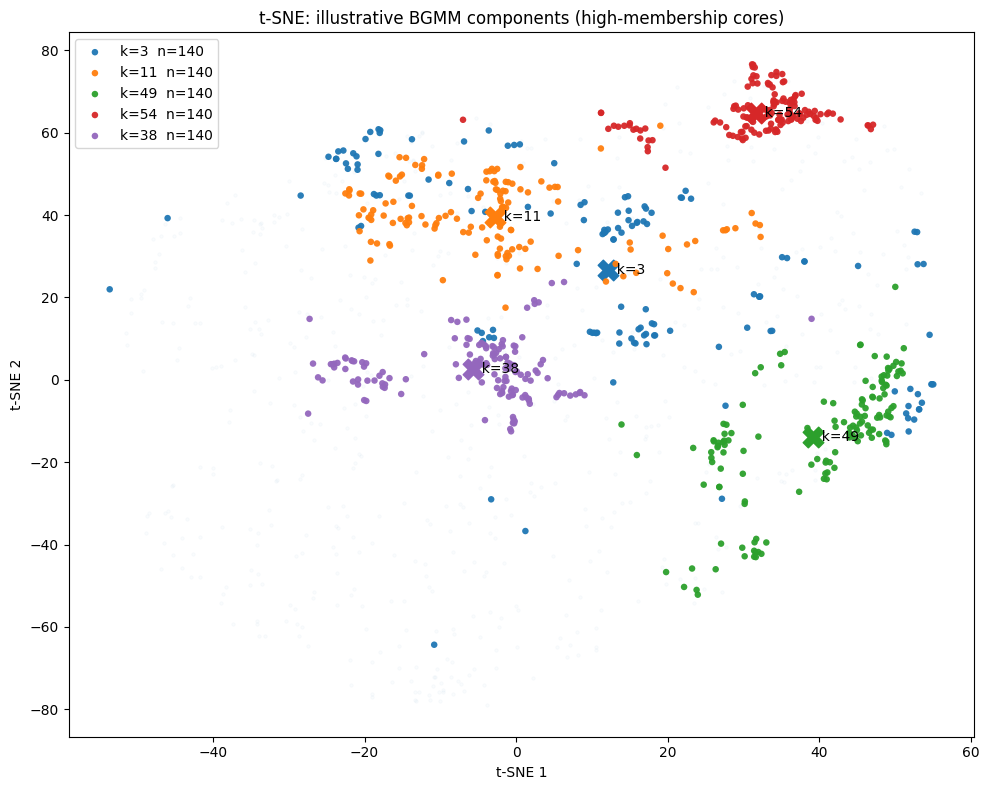

k=3: n=140  r_ik min/med/max = 1.000 / 1.000 / 1.000
k=11: n=140  r_ik min/med/max = 0.999 / 1.000 / 1.000
k=49: n=140  r_ik min/med/max = 1.000 / 1.000 / 1.000
k=54: n=140  r_ik min/med/max = 1.000 / 1.000 / 1.000
k=38: n=140  r_ik min/med/max = 0.999 / 1.000 / 1.000


In [ ]:
# Illustrative example
# Cell X (ILLUSTRATIVE). t-SNE showing selected BGMM components as clean islands
# Components kept for illustration: k = [4, 16, 41, 60, 23]

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

Z = np.asarray(Z, dtype=np.float64)
resp = np.asarray(resp, dtype=np.float64)
nE, d = Z.shape

# ---------- fixed components for illustration ----------
ks = [51, 18, 15, 75, 13]
print("Illustrative components:", ks)

# ---------- embed (t-SNE) ----------
perplexity = 80
tsne = TSNE(
    n_components=2,
    perplexity=min(perplexity, (nE - 1) // 3),
    init="random",
    random_state=0,
    early_exaggeration=36.0,
    learning_rate="auto",
    max_iter=3000,
    verbose=1,
)
Y = tsne.fit_transform(Z)

# ---------- high-membership core selection ----------
TAU = 1          # raise for tighter islands (0.7–0.8 even cleaner)
MAX_PER = 180
MIN_PER = 40
FALLBACK_TOPN = 140

picked = {}
picked_r = {}
centroid = {}

for k in ks:
    rik = resp[:, k].astype(np.float64)
    ok = np.isfinite(rik)
    idx = np.where(ok)[0]
    if idx.size == 0:
        picked[k] = np.array([], dtype=int)
        continue

    # core by threshold
    sel = idx[rik[idx] >= TAU]

    if sel.size < MIN_PER:
        order = idx[np.argsort(rik[idx])[::-1]]
        sel = order[:min(FALLBACK_TOPN, order.size)]

    if sel.size > MAX_PER:
        order = sel[np.argsort(rik[sel])[::-1]]
        sel = order[:MAX_PER]

    picked[k] = sel
    picked_r[k] = rik[sel]
    centroid[k] = (float(np.mean(Y[sel, 0])), float(np.mean(Y[sel, 1])))

# ---------- plotting ----------
cmap = plt.get_cmap("tab10")
color_for_k = {k: cmap(i % 10) for i, k in enumerate(ks)}

rng = np.random.default_rng(0)

# faint background subsample
BG_N = 600
bg_idx = rng.choice(np.arange(nE), size=min(BG_N, nE), replace=False)

plt.figure(figsize=(10, 8))
plt.scatter(Y[bg_idx, 0], Y[bg_idx, 1], s=6, alpha=0.02)

handles, labels = [], []

for k in ks:
    sel = picked[k]
    if sel.size == 0:
        continue

    col = color_for_k[k]

    sc = plt.scatter(
        Y[sel, 0], Y[sel, 1],
        s=22,
        alpha=0.95,
        color=col,
        edgecolors="none",
    )

    # centroid marker
    cx, cy = centroid[k]
    plt.scatter([cx], [cy], s=220, marker="X", color=col, alpha=1.0)
    plt.text(cx, cy, f"  k={k}", fontsize=10, va="center")

    handles.append(sc)
    labels.append(f"k={k}  n={sel.size}")

plt.title("t-SNE: illustrative BGMM components (high-membership cores)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(handles, labels, frameon=True)
plt.tight_layout()
plt.show()

# ---------- quick compactness stats ----------
for k in ks:
    r = picked_r[k]
    print(
        f"k={k}: n={picked[k].size}  "
        f"r_ik min/med/max = {float(r.min()):.3f} / {float(np.median(r)):.3f} / {float(r.max()):.3f}"
    )


In [57]:
import numpy as np

resp = np.asarray(resp, dtype=np.float64)

# You already have this upstream
# ks = [77, 52, 55, 58, 22]
TOPN = 5

# --- safety: make sure ks are valid column indices for resp ---
K = resp.shape[1]
bad = [k for k in ks if (k < 0 or k >= K)]
assert len(bad) == 0, f"Some ks are out of bounds for resp (n_cols={K}): {bad}"

top_members = {}  # k -> global indices (into png_paths / polygons)

for k in ks:
    rik = resp[:, int(k)]
    ok = np.isfinite(rik)
    idx = np.where(ok)[0]

    # rank descending by responsibility r_ik
    order = idx[np.argsort(rik[idx])[::-1]]
    sel_j = order[:min(TOPN, order.size)]  # eligible indices (rows of resp)

    # map eligible index j -> global index i (for png_paths/polygons)
    if "E_idx" in globals() and len(E_idx) == resp.shape[0]:
        sel_i = np.asarray(E_idx, dtype=int)[sel_j]
    else:
        sel_i = sel_j

    top_members[int(k)] = sel_i.astype(int)

print("top_members (k -> global indices):")
for k in ks:
    print(k, ":", top_members[int(k)].tolist())


top_members (k -> global indices):
3 : [7793, 9269, 2771, 2009, 2481]
11 : [7804, 2518, 7629, 4919, 133]
49 : [1843, 4324, 7705, 5206, 986]
54 : [2974, 207, 3615, 2278, 9053]
38 : [7225, 7801, 4729, 6817, 1634]


In [58]:
import base64
from pathlib import Path
from PIL import Image

# --- where to save ---
SVG_DIR = (OUT_DIR / "top_members_svgs") if "OUT_DIR" in globals() else Path(".") / "top_members_svgs"
SVG_DIR.mkdir(parents=True, exist_ok=True)

def save_png_as_embedded_svg(png_path: Path, svg_path: Path):
    # Read image to get dimensions
    with Image.open(png_path) as im:
        w, h = im.size

    # Base64-encode PNG bytes
    png_bytes = png_path.read_bytes()
    b64 = base64.b64encode(png_bytes).decode("ascii")

    # SVG that embeds the PNG
    svg = f"""<?xml version="1.0" encoding="UTF-8"?>
<svg xmlns="http://www.w3.org/2000/svg"
     xmlns:xlink="http://www.w3.org/1999/xlink"
     width="{w}" height="{h}" viewBox="0 0 {w} {h}">
  <image width="{w}" height="{h}" x="0" y="0"
         xlink:href="data:image/png;base64,{b64}" />
</svg>
"""
    svg_path.write_text(svg, encoding="utf-8")

# --- save all top members ---
assert "CASE_ID" in globals(), "CASE_ID must be set upstream."
assert "png_paths" in globals(), "png_paths must exist (list of paths aligned to global indices)."

for cluster_rank, k in enumerate(ks, start=1):          # 77->1, 52->2, ...
    for image_rank, i in enumerate(top_members[k], start=1):  # 1..TOPN
        png_path = Path(png_paths[int(i)])
        svg_name = f"{CASE_ID}_cluster{cluster_rank}_img{image_rank}.svg"
        svg_path = SVG_DIR / svg_name
        save_png_as_embedded_svg(png_path, svg_path)

print(f"Saved SVGs to: {SVG_DIR.resolve()}")


Saved SVGs to: /home/hschatzle/monte-carlo-selection/results/top_members_svgs


# Choose hypothesis by debiased mass

In [21]:
# Cell. B1 Choose strongest hypothesis (component) by debiased mass
import numpy as np

# expects: active_df with columns ["k","mass_debias","mix_weight"] sorted desc by mass_debias
k_star = int(active_df.iloc[0]["k"])
mass_star = float(active_df.iloc[0]["mass_debias"])
mixw_star = float(active_df.iloc[0]["mix_weight"])

print("Strongest hypothesis k* =", k_star)
print("  mass_debias:", mass_star)
print("  mix_weight :", mixw_star)


Strongest hypothesis k* = 9
  mass_debias: 1020.1217857548747
  mix_weight : 0.10200254904438136


In [22]:
# Cell 2 (FIXED). Align tlog to the same eligible set as resp, then pick representative for k*
import numpy as np
from pathlib import Path

# resp is computed on the PCA/BGMM subset (Z). Its rows define the "eligible set" for clustering:
nE = int(resp.shape[0])

# We need tlog to be length nE and in the same order.
# Common situations:
#  (A) you already have tlog_E for that subset
#  (B) you only have tlog_all for all 10k completions. then you must index with E_idx.
# This cell handles both robustly.

# 1) choose the correct tlog array aligned to resp rows
if "tlog_E" in globals() and len(tlog_E) == nE:
    tlog_aligned = np.asarray(tlog_E, dtype=np.float64)
elif "tlog" in globals() and len(tlog) == nE:
    tlog_aligned = np.asarray(tlog, dtype=np.float64)
elif "tlog" in globals() and "E_idx" in globals() and len(tlog) >= int(np.max(E_idx)) + 1:
    # tlog is "global" (length N_total). align using E_idx (length nE)
    tlog_aligned = np.asarray(tlog, dtype=np.float64)[np.asarray(E_idx, dtype=int)]
else:
    raise RuntimeError(
        "Cannot align tlog to resp rows.\n"
        f"resp rows nE={nE}\n"
        f"Available: tlog len={len(tlog) if 'tlog' in globals() else 'NA'}, "
        f"E_idx len={len(E_idx) if 'E_idx' in globals() else 'NA'}, "
        f"tlog_E len={len(tlog_E) if 'tlog_E' in globals() else 'NA'}\n"
        "Fix: ensure you either compute logits only for the eligible subset (tlog_E), "
        "or keep tlog for all completions and provide E_idx used to build Z/resp."
    )

# 2) responsibilities for the strongest hypothesis
rik = resp[:, int(k_star)].astype(np.float64)

finite = np.isfinite(rik) & np.isfinite(tlog_aligned)
if int(finite.sum()) == 0:
    raise RuntimeError("No finite responsibilities/logits after alignment.")

cand = np.where(finite)[0]

# Representative: maximize r_ik, tie-break by target_logit
order = np.lexsort((tlog_aligned[cand], rik[cand]))
best_j = int(cand[order[-1]])              # index in eligible/clustering set (0..nE-1)

# Map to global index for png_paths
if "E_idx" in globals() and len(E_idx) == nE:
    best_i = int(np.asarray(E_idx, dtype=int)[best_j])
else:
    # If clustering was done on all completions, best_j is already global
    best_i = best_j

best_path = Path(png_paths[best_i])



print("Representative completion for k* (aligned):")
print("  k*:", int(k_star))
print("  eligible j:", best_j, " global i:", best_i)
print("  png:", best_path.name)
print("  r_ik:", float(rik[best_j]))
print("  target_logit:", float(tlog_aligned[best_j]))
if "occ_tlog" in globals():
    print("  baseline target_logit:", float(occ_tlog))


Representative completion for k* (aligned):
  k*: 9
  eligible j: 7965  global i: 7965
  png: completion_0001_07966.png
  r_ik: 0.999998405125332
  target_logit: 7.112832069396973
  baseline target_logit: 7.087069988250732


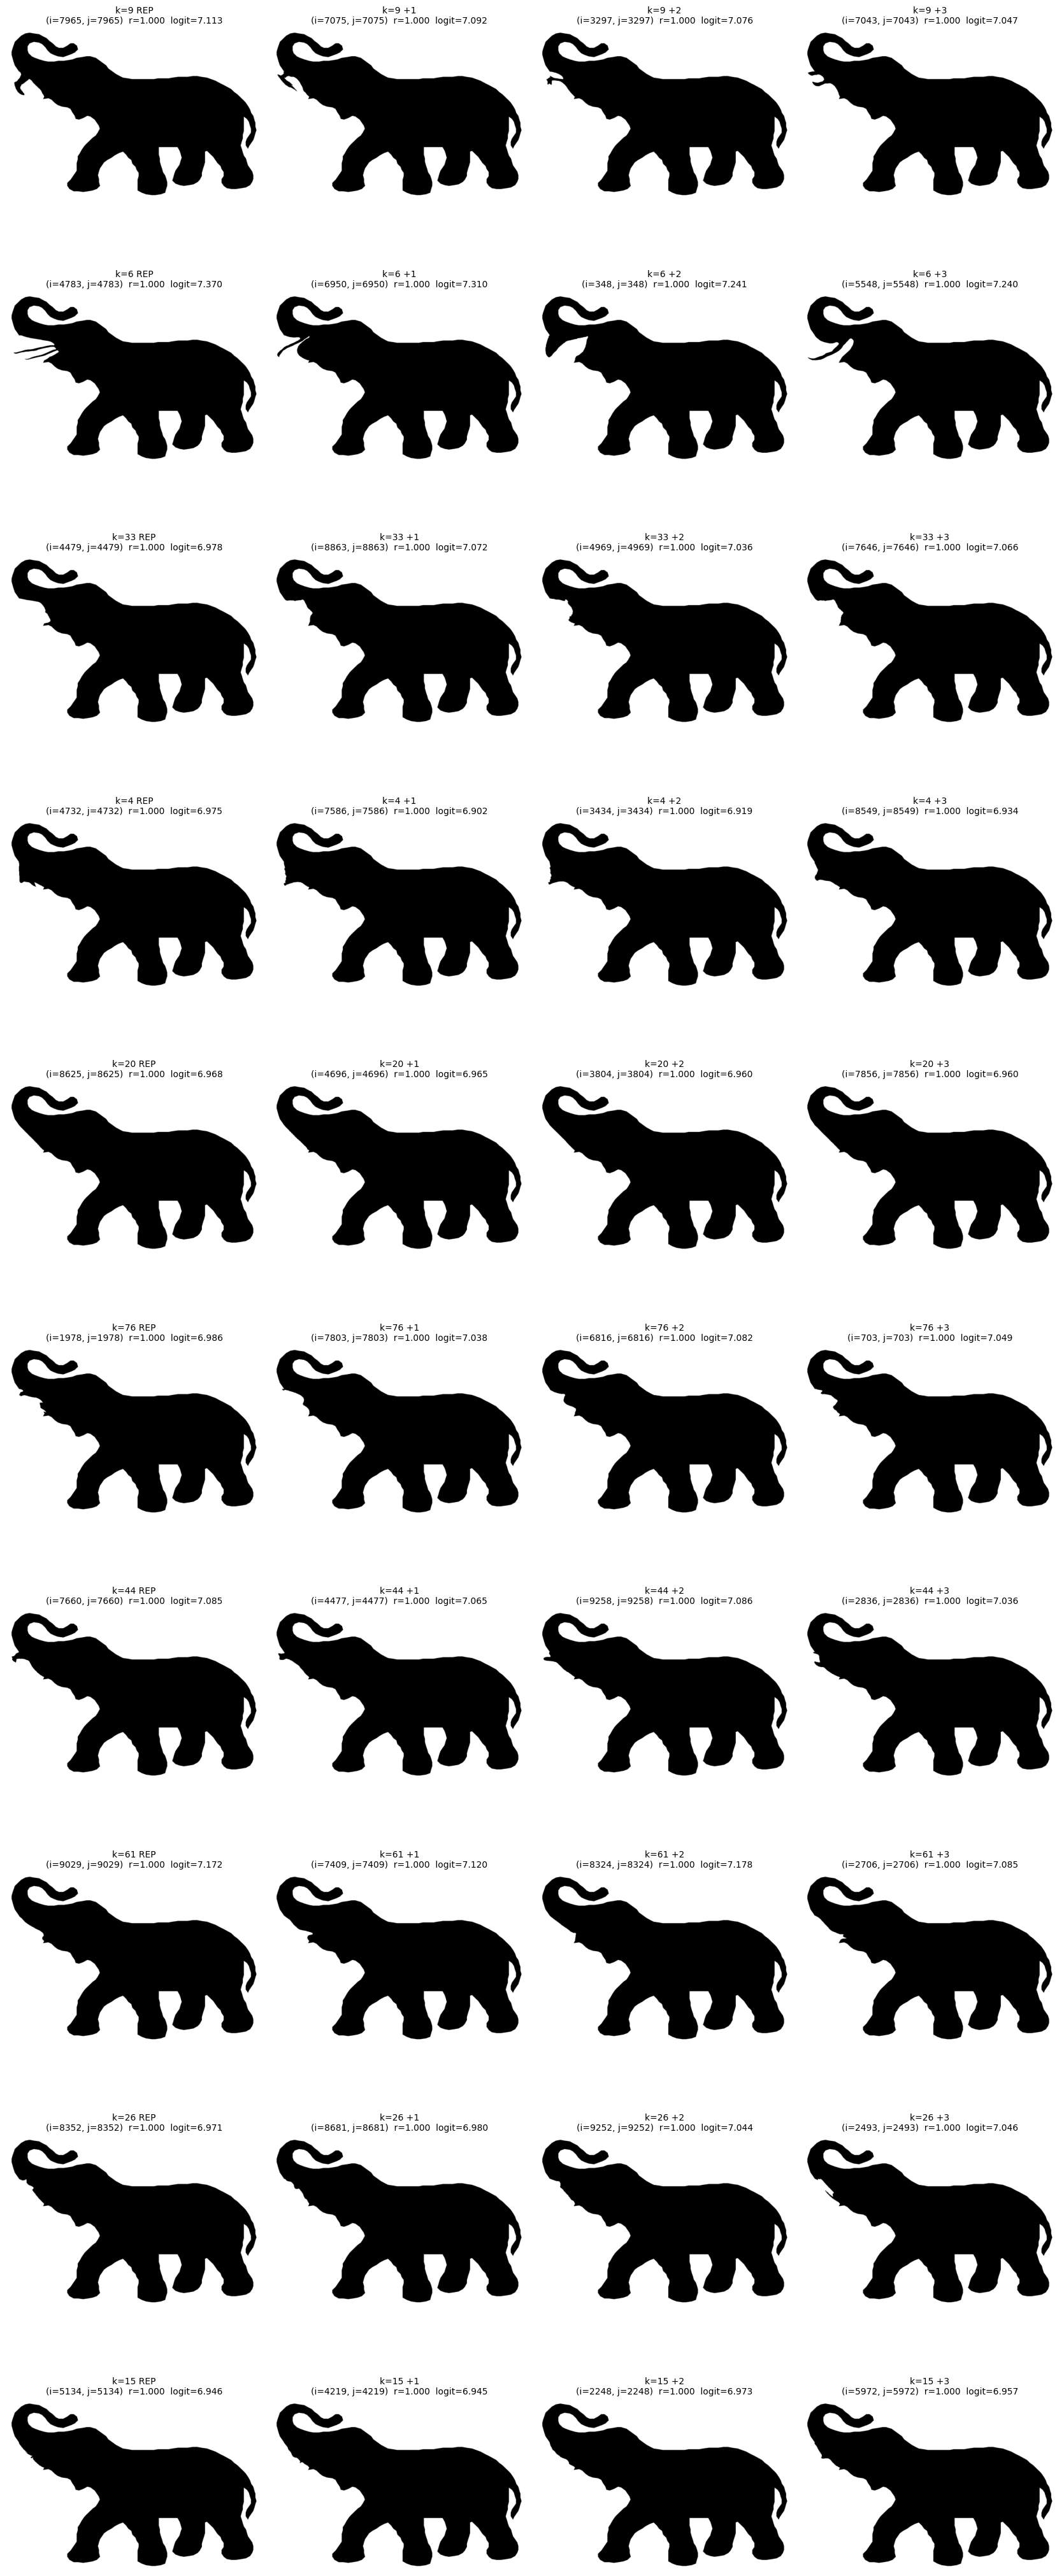

k=9 representative: completion_0001_07966.png (global i=7965)
k=6 representative: completion_0001_04784.png (global i=4783)
k=33 representative: completion_0001_04480.png (global i=4479)
k=4 representative: completion_0001_04733.png (global i=4732)
k=20 representative: completion_0001_08626.png (global i=8625)
k=76 representative: completion_0001_01979.png (global i=1978)
k=44 representative: completion_0001_07661.png (global i=7660)
k=61 representative: completion_0001_09030.png (global i=9029)
k=26 representative: completion_0001_08353.png (global i=8352)
k=15 representative: completion_0001_05135.png (global i=5134)


In [29]:
# Cell X. Visualize representative + 3 extra completions for the top-3 clusters (by mass_debias)
# Assumes you have: active_df, resp, png_paths, and either (tlog_E) or (tlog + E_idx) as in your alignment cell.
# Shows a 3 (clusters) × 4 (samples) grid: [REP | +1 | +2 | +3], with r_ik and target_logit in titles.

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# ---- helpers ----
def align_tlog_to_resp_rows(resp, tlog=None, tlog_E=None, E_idx=None):
    nE = int(resp.shape[0])
    if tlog_E is not None and len(tlog_E) == nE:
        return np.asarray(tlog_E, dtype=np.float64), None  # already aligned, no global mapping needed
    if tlog is not None and len(tlog) == nE:
        return np.asarray(tlog, dtype=np.float64), None
    if tlog is not None and E_idx is not None and len(E_idx) == nE and len(tlog) >= int(np.max(E_idx)) + 1:
        return np.asarray(tlog, dtype=np.float64)[np.asarray(E_idx, dtype=int)], np.asarray(E_idx, dtype=int)
    raise RuntimeError("Cannot align tlog to resp rows. Provide tlog_E (len=nE) or (tlog + E_idx).")

def pick_topk_indices_for_component(resp, k, tlog_aligned, k_total=4, global_map=None):
    # returns list of global indices into png_paths, plus aligned indices, plus scores
    rik = np.asarray(resp[:, int(k)], dtype=np.float64)
    ok = np.isfinite(rik) & np.isfinite(tlog_aligned)

    cand = np.where(ok)[0]
    if cand.size == 0:
        return [], [], []

    # rank by (r_ik, then tlog) descending
    order = np.lexsort((tlog_aligned[cand], rik[cand]))
    ranked = cand[order[::-1]]

    chosen_j = ranked[:k_total].tolist()

    if global_map is None:
        chosen_i = chosen_j
    else:
        chosen_i = [int(global_map[j]) for j in chosen_j]

    meta = [(float(rik[j]), float(tlog_aligned[j])) for j in chosen_j]
    return chosen_i, chosen_j, meta

def load_img(path):
    return Image.open(path).convert("RGBA")

# ---- pick top 3 clusters by debiased mass ----
top3 = active_df.sort_values("mass_debias", ascending=False).head(10).copy()
ks = [int(k) for k in top3["k"].values]

# ---- align logits to resp rows (exactly like your alignment logic) ----
tlog_aligned, global_map = align_tlog_to_resp_rows(
    resp,
    tlog=(globals().get("tlog", None)),
    tlog_E=(globals().get("tlog_E", None)),
    E_idx=(globals().get("E_idx", None)),
)

# ---- gather selections ----
ncols = 4  # REP + 3 extras
selections = []
for k in ks:
    chosen_i, chosen_j, meta = pick_topk_indices_for_component(
        resp, k, tlog_aligned, k_total=ncols, global_map=global_map
    )
    selections.append((k, chosen_i, chosen_j, meta))

# ---- plot grid ----
fig, axes = plt.subplots(nrows=len(ks), ncols=ncols, figsize=(4.2*ncols, 4.2*len(ks)))
if len(ks) == 1:
    axes = np.expand_dims(axes, axis=0)

for r, (k, chosen_i, chosen_j, meta) in enumerate(selections):
    for c in range(ncols):
        ax = axes[r, c]
        ax.axis("off")

        if c >= len(chosen_i):
            ax.set_title("none", fontsize=10)
            continue

        i = int(chosen_i[c])  # global index into png_paths
        j = int(chosen_j[c])  # aligned index into resp/tlog_aligned
        rik_val, tlog_val = meta[c]

        p = Path(png_paths[i])
        img = load_img(p)

        ax.imshow(img)
        tag = "REP" if c == 0 else f"+{c}"
        ax.set_title(f"k={k} {tag}\n(i={i}, j={j})  r={rik_val:.3f}  logit={tlog_val:.3f}", fontsize=10)

plt.tight_layout()
plt.show()

# Also print the representative paths for copy/paste convenience
for (k, chosen_i, chosen_j, meta) in selections:
    if len(chosen_i):
        rep_i = chosen_i[0]
        print(f"k={k} representative: {Path(png_paths[int(rep_i)]).name} (global i={int(rep_i)})")


# Comparison

In [40]:
# Cell. Certainty metrics from logits (softmax, margin, entropy, energy)
import numpy as np

def softmax(logits: np.ndarray) -> np.ndarray:
    z = np.asarray(logits, dtype=np.float64).reshape(-1)
    z = z - np.max(z)
    e = np.exp(z)
    return e / (np.sum(e) + 1e-12)

def certainty_metrics(logits: np.ndarray) -> dict:
    z = np.asarray(logits, dtype=np.float64).reshape(-1)
    p = softmax(z)
    k = int(np.argmax(z))
    z_top = float(z[k])
    z_2nd = float(np.max(np.delete(z, k))) if z.size > 1 else float("-inf")
    margin = z_top - z_2nd
    p_top = float(np.max(p))
    entropy = float(-np.sum(p * np.log(p + 1e-12)))
    energy = float(np.log(np.sum(np.exp(z - np.max(z))) + 1e-12) + np.max(z))  # logsumexp
    return {
        "pred_idx": k,
        "pred_logit": z_top,
        "margin_top2": float(margin),
        "p_top1": p_top,
        "entropy": entropy,
        "energy_logsumexp": energy,
    }


In [41]:
# Cell. Compare certainty: best completion vs ground truth vs occluded (FIXED)
from pathlib import Path
import numpy as np

OCC_PNG  = Path(OCCLUDED_PNG)
BEST_PNG = COMPLETIONS_DIR / best_path
# --------------------------------------------------
# Inference
# --------------------------------------------------
_, logits_best = infer_penult_and_logits(BEST_PNG)
_, logits_gt   = infer_penult_and_logits(GT_PNG)
_, logits_occ  = infer_penult_and_logits(OCC_PNG)

# --------------------------------------------------
# Certainty metrics
# --------------------------------------------------
m_best = certainty_metrics(logits_best)
m_gt   = certainty_metrics(logits_gt)
m_occ  = certainty_metrics(logits_occ)

def pretty(m):
    cls = classes[m["pred_idx"]] if "classes" in globals() else str(m["pred_idx"])
    return {**m, "pred_class": cls}

print("BEST:", pretty(m_best))
print("GT  :", pretty(m_gt))
print("OC  :", pretty(m_occ))

# --------------------------------------------------
# Differences
# --------------------------------------------------
delta_best_gt = {
    "delta_margin":  m_best["margin_top2"]      - m_gt["margin_top2"],
    "delta_entropy": m_best["entropy"]          - m_gt["entropy"],
    "delta_p_top1":  m_best["p_top1"]           - m_gt["p_top1"],
    "delta_energy":  m_best["energy_logsumexp"] - m_gt["energy_logsumexp"],
}

delta_gt_occ = {
    "delta_margin":  m_gt["margin_top2"]      - m_occ["margin_top2"],
    "delta_entropy": m_gt["entropy"]          - m_occ["entropy"],
    "delta_p_top1":  m_gt["p_top1"]           - m_occ["p_top1"],
    "delta_energy":  m_gt["energy_logsumexp"] - m_occ["energy_logsumexp"],
}

print("\nΔ (best - gt):", delta_best_gt)
print("Δ (gt - occ):", delta_gt_occ)


BEST: {'pred_idx': 18, 'pred_logit': 5.151575088500977, 'margin_top2': 1.7973270416259766, 'p_top1': 0.5140113333657145, 'entropy': 2.2132666420269356, 'energy_logsumexp': 5.817085052921392, 'pred_class': 'dolphin'}
GT  : {'pred_idx': 21, 'pred_logit': 5.286025047302246, 'margin_top2': 0.5539960861206055, 'p_top1': 0.3076516990368475, 'entropy': 2.368362269441244, 'energy_logsumexp': 6.464812030484017, 'pred_class': 'elephant'}
OC  : {'pred_idx': 18, 'pred_logit': 2.2445013523101807, 'margin_top2': 0.27215123176574707, 'p_top1': 0.10497279284672602, 'entropy': 3.5206027358713965, 'energy_logsumexp': 4.4985554304565465, 'pred_class': 'dolphin'}

Δ (best - gt): {'delta_margin': 1.243330955505371, 'delta_entropy': -0.15509562741430827, 'delta_p_top1': 0.20635963432886695, 'delta_energy': -0.6477269775626251}
Δ (gt - occ): {'delta_margin': 0.2818448543548584, 'delta_entropy': -1.1522404664301527, 'delta_p_top1': 0.20267890619012152, 'delta_energy': 1.9662566000274708}


Appended metrics → /home/hschatzle/monte-carlo-selection/results/certainty_metrics.jsonl


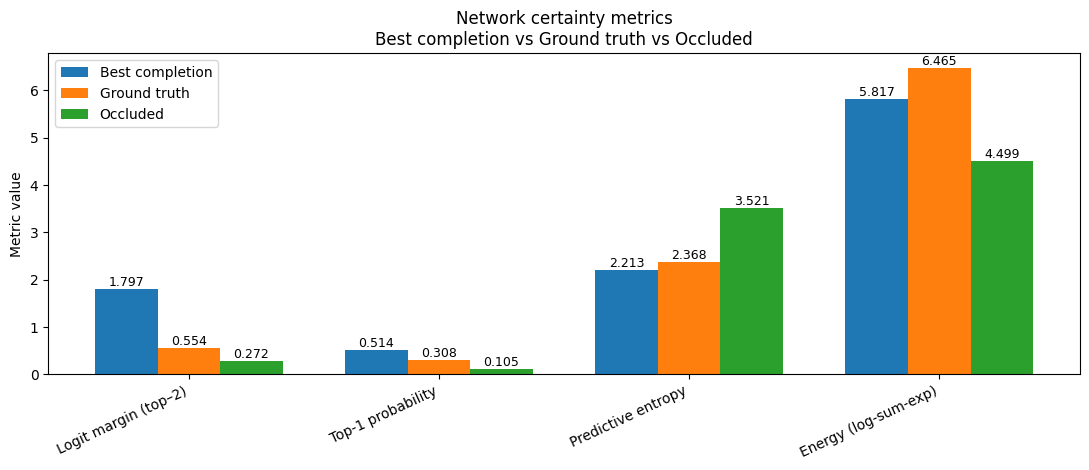

Metric interpretation:
  Logit margin (top–2): higher = more certain
  Top-1 probability: higher = more certain
  Predictive entropy: lower = more certain
  Energy (log-sum-exp): higher = more certain

Predicted classes:
  BEST: dolphin
  GT  : elephant
  OCC : dolphin


In [42]:
# Cell. Visualize + save certainty metrics: Best vs GT vs Occluded (FIXED)
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


OUT_DIR = ROOT / "results"  # <- fixed location
OUT_DIR.mkdir(parents=True, exist_ok=True)
JSONL_PATH = OUT_DIR / "certainty_metrics.jsonl"


# --------------------------------------------------
# Compute metrics
# --------------------------------------------------
_, logits_best = infer_penult_and_logits(BEST_PNG)
_, logits_gt   = infer_penult_and_logits(GT_PNG)
_, logits_occ  = infer_penult_and_logits(OCC_PNG)

m_best = certainty_metrics(logits_best)
m_gt   = certainty_metrics(logits_gt)
m_occ  = certainty_metrics(logits_occ)

metrics = [
    ("margin_top2",      "Logit margin (top–2)",        "higher = more certain"),
    ("p_top1",           "Top-1 probability",           "higher = more certain"),
    ("entropy",          "Predictive entropy",          "lower = more certain"),
    ("energy_logsumexp", "Energy (log-sum-exp)",        "higher = more certain"),
]

labels    = [m[1] for m in metrics]
best_vals = [m_best[m[0]] for m in metrics]
gt_vals   = [m_gt[m[0]]   for m in metrics]
occ_vals  = [m_occ[m[0]]  for m in metrics]



# --------------------------------------------------
# Save to JSONL (append one row, timestamped)
# --------------------------------------------------
from datetime import datetime, timezone

def _cls_name(m):
    return classes[m["pred_idx"]] if "classes" in globals() else str(m["pred_idx"])

row = {
    "timestamp_utc": datetime.now(timezone.utc).isoformat(timespec="seconds"),
    "case_id": str(CASE_ID) if "CASE_ID" in globals() else None,

    "best_png": str(BEST_PNG),
    "gt_png":   str(GT_PNG),
    "occ_png":  str(OCC_PNG),

    "best_pred_idx": int(m_best["pred_idx"]),
    "gt_pred_idx":   int(m_gt["pred_idx"]),
    "occ_pred_idx":  int(m_occ["pred_idx"]),
    "best_pred_class": _cls_name(m_best),
    "gt_pred_class":   _cls_name(m_gt),
    "occ_pred_class":  _cls_name(m_occ),

    "metrics": {
        key: {
            "best": float(m_best[key]),
            "gt":   float(m_gt[key]),
            "occ":  float(m_occ[key]),
            "direction": interp
        }
        for key, _, interp in metrics
    },

    "deltas": {
        "best_minus_gt": {
            "margin_top2":      float(m_best["margin_top2"]      - m_gt["margin_top2"]),
            "p_top1":           float(m_best["p_top1"]           - m_gt["p_top1"]),
            "entropy":          float(m_best["entropy"]          - m_gt["entropy"]),
            "energy_logsumexp": float(m_best["energy_logsumexp"] - m_gt["energy_logsumexp"]),
        },
        "gt_minus_occ": {
            "margin_top2":      float(m_gt["margin_top2"]      - m_occ["margin_top2"]),
            "p_top1":           float(m_gt["p_top1"]           - m_occ["p_top1"]),
            "entropy":          float(m_gt["entropy"]          - m_occ["entropy"]),
            "energy_logsumexp": float(m_gt["energy_logsumexp"] - m_occ["energy_logsumexp"]),
        },
    },
}

with JSONL_PATH.open("a", encoding="utf-8") as f:
    f.write(json.dumps(row, ensure_ascii=False) + "\n")

print(f"Appended metrics → {JSONL_PATH}")


# --------------------------------------------------
# Visualization
# --------------------------------------------------
x = np.arange(len(metrics))
w = 0.25

plt.figure(figsize=(11, 4.8))
plt.bar(x - w, best_vals, width=w, label="Best completion")
plt.bar(x,      gt_vals,  width=w, label="Ground truth")
plt.bar(x + w,  occ_vals, width=w, label="Occluded")

for i, v in enumerate(best_vals):
    plt.text(i - w, v, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(gt_vals):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(occ_vals):
    plt.text(i + w, v, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

plt.xticks(x, labels, rotation=25, ha="right")
plt.ylabel("Metric value")
plt.title("Network certainty metrics\nBest completion vs Ground truth vs Occluded")
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------------------------------
# Textual reminder
# --------------------------------------------------
print("Metric interpretation:")
for _, name, interp in metrics:
    print(f"  {name}: {interp}")

print("\nPredicted classes:")
print("  BEST:", _cls_name(m_best))
print("  GT  :", _cls_name(m_gt))
print("  OCC :", _cls_name(m_occ))


# Visualization

Will export to: /home/hschatzle/monte-carlo-selection/notebooks/tsne_panelA.svg


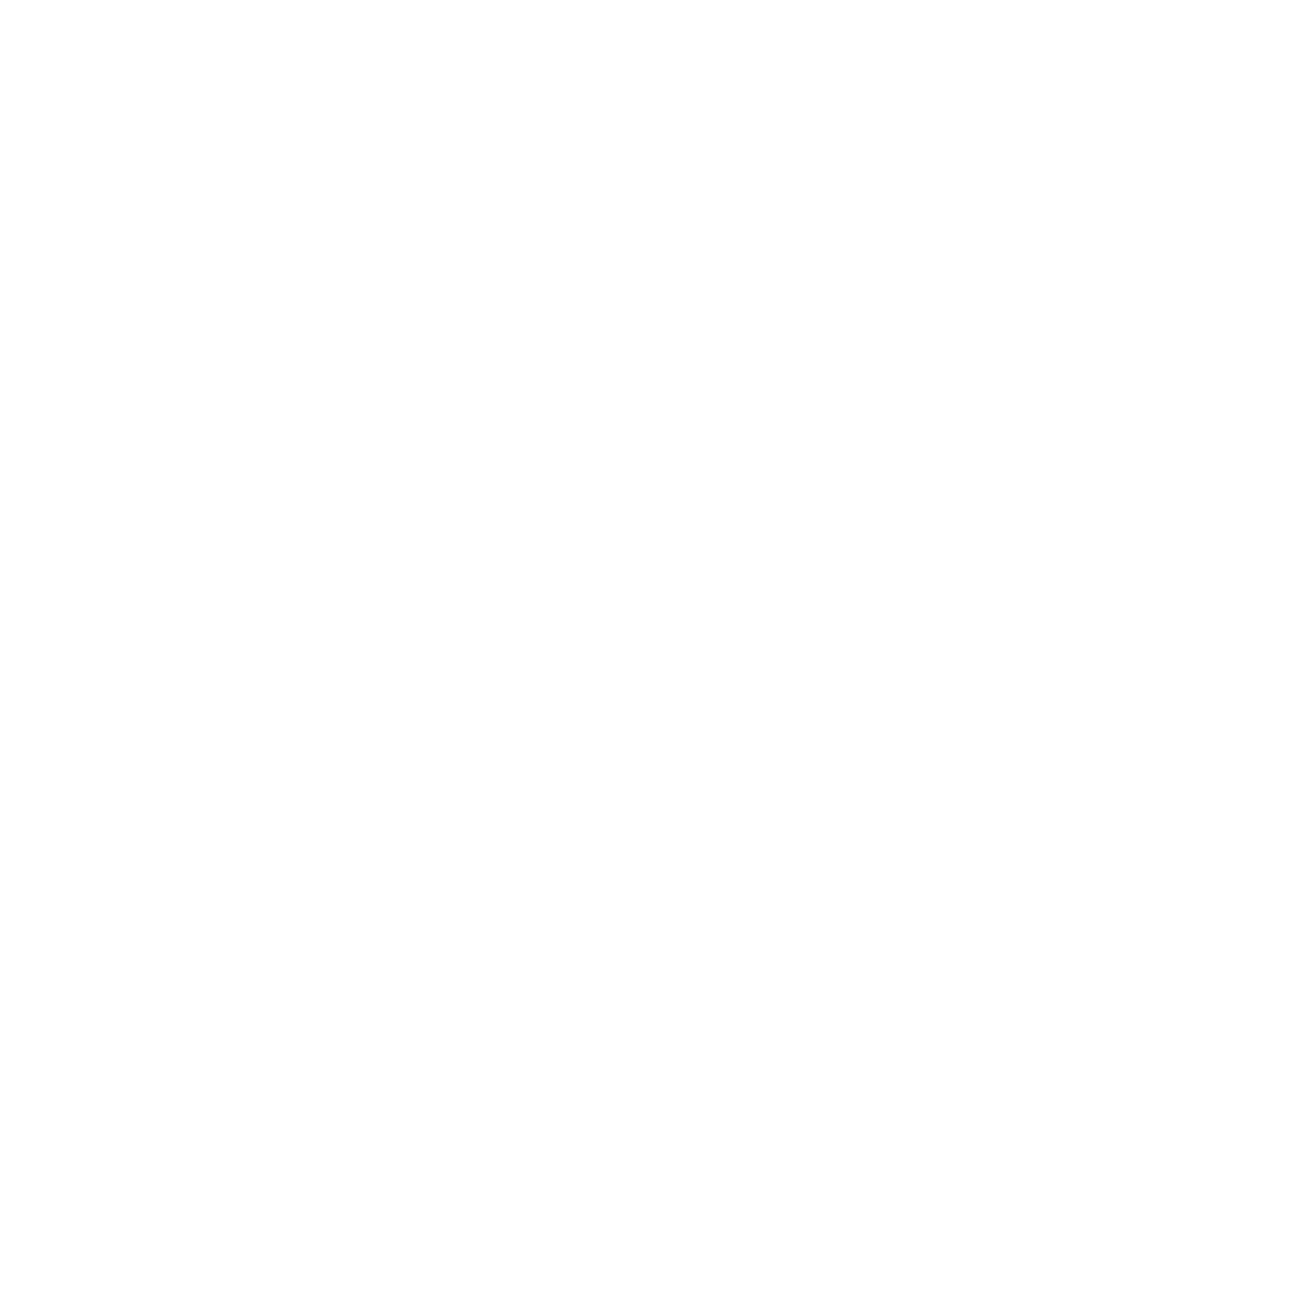

In [77]:
# Step 1. Publication-ready styling + SVG export scaffold (no selection logic yet)

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Required: Y (nE,2) already computed OR we compute it later.
# For now, assume you have Y from your t-SNE cell. If not, keep this cell and run after Y exists.

# ---- style knobs (Nature-like) ----
FIG_W, FIG_H = 4.2, 4.2          # inches. square panel
DPI = 300                         # for raster exports. SVG ignores but fine to keep.

S_BG = 10                         # background dot size
A_BG = 0.02                       # background opacity
BG_N = 1200                       # background subsample count

S_FG = 34                         # foreground dot size (bigger = rounder look)
A_FG = 0.90                       # foreground opacity
EDGE = "none"                     # no marker outline

# ---- output path ----
OUT = Path("tsne_panelA.svg")     # change if you want
print("Will export to:", OUT.resolve())

# ---- create empty figure scaffold (we'll add points in Step 2) ----
fig, ax = plt.subplots(figsize=(FIG_W, FIG_H), dpi=DPI)

# clean axes like Nature
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

# NOTE: In Step 2 we will:
#  - plot faint background (subsample)
#  - overlay selected components with discrete colors
#  - add labels/centroids (optional)
#  - export

plt.tight_layout(pad=0.2)
plt.show()


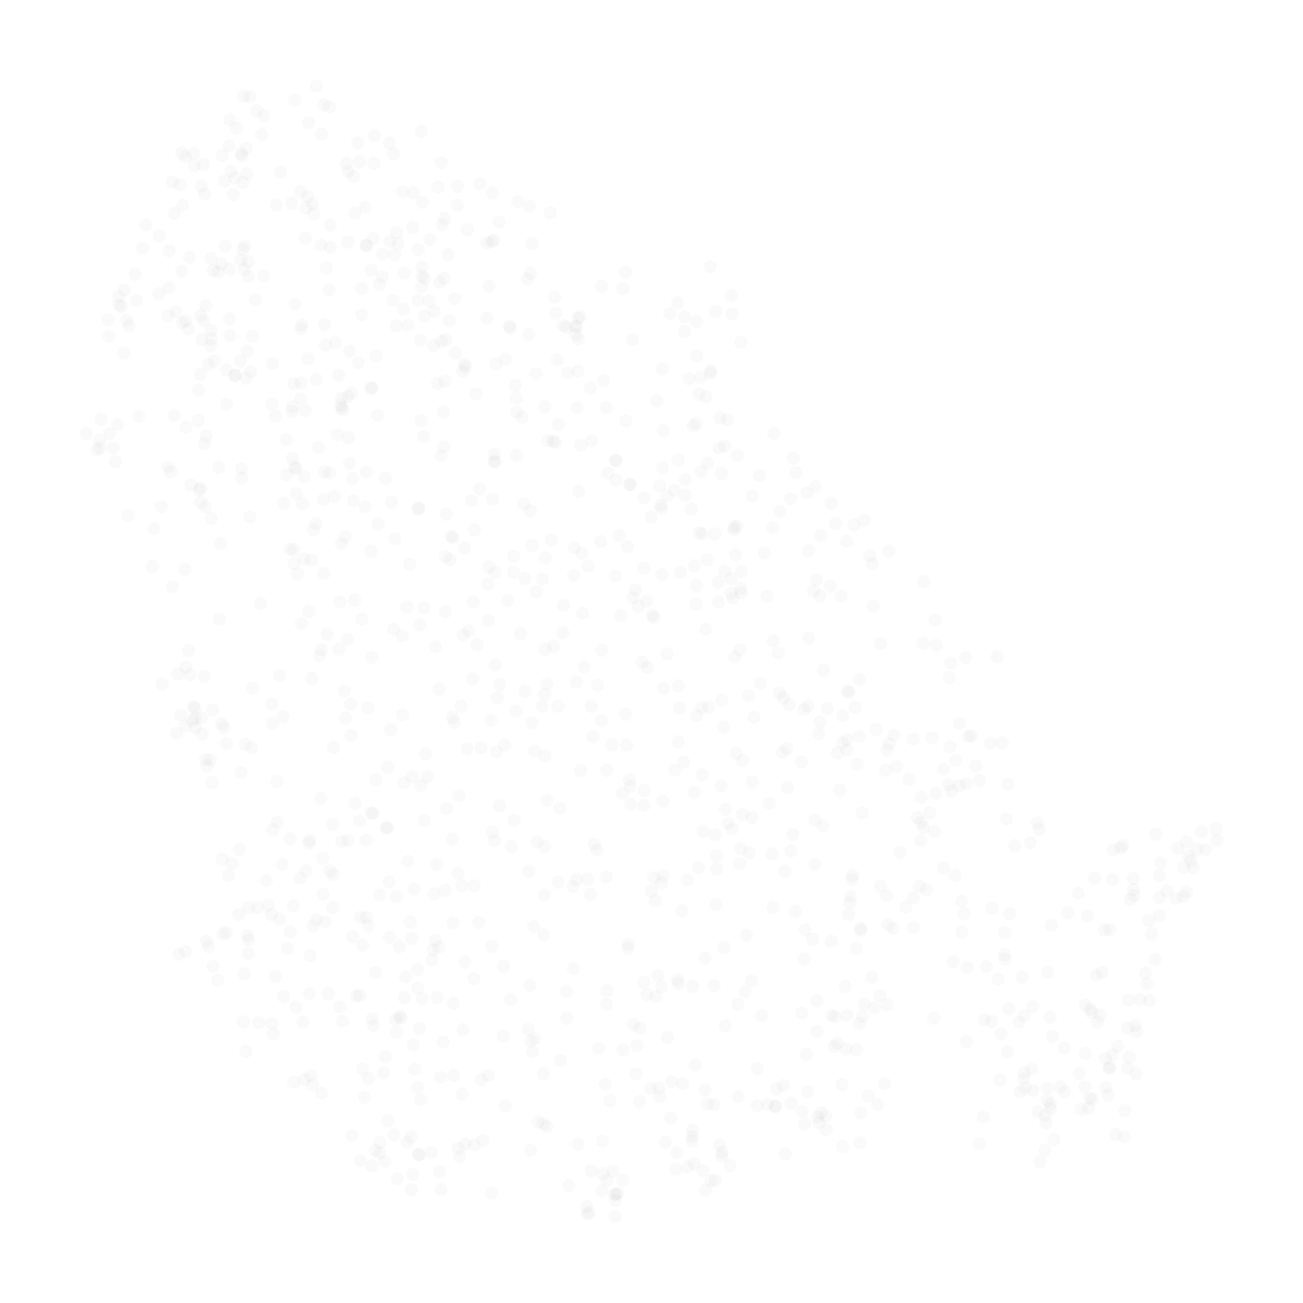

Exported: /home/hschatzle/monte-carlo-selection/notebooks/tsne_panelA_base_bg.svg
Background: plotted 1200 / 10000 points (alpha=0.02, size=10).


In [78]:
# Step 2. Add faint background cloud (subsampled) + export base SVG

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Requires: Y as (nE,2) t-SNE coords already computed
Y = np.asarray(Y, dtype=np.float64)
nE = Y.shape[0]

# ---- style knobs (from Step 1, repeat here for single-cell robustness) ----
FIG_W, FIG_H = 4.2, 4.2
DPI = 300

S_BG = 10
A_BG = 0.02
BG_N = 1200

OUT = Path("tsne_panelA_base_bg.svg")

rng = np.random.default_rng(0)
bg_idx = rng.choice(np.arange(nE), size=min(BG_N, nE), replace=False)

fig, ax = plt.subplots(figsize=(FIG_W, FIG_H), dpi=DPI)

# background points
ax.scatter(
    Y[bg_idx, 0], Y[bg_idx, 1],
    s=S_BG,
    alpha=A_BG,
    c="black",
    marker="o",
    edgecolors="none",
    linewidths=0
)

# clean axes
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout(pad=0.2)

# export as SVG for Illustrator
fig.savefig(OUT, format="svg", bbox_inches="tight", pad_inches=0.02)
plt.show()

print("Exported:", OUT.resolve())
print(f"Background: plotted {len(bg_idx)} / {nE} points (alpha={A_BG}, size={S_BG}).")


Component → label mapping:
4 → Hypothesis 1
16 → Hypothesis 2
41 → Hypothesis 3
60 → Hypothesis 4
23 → Hypothesis 5


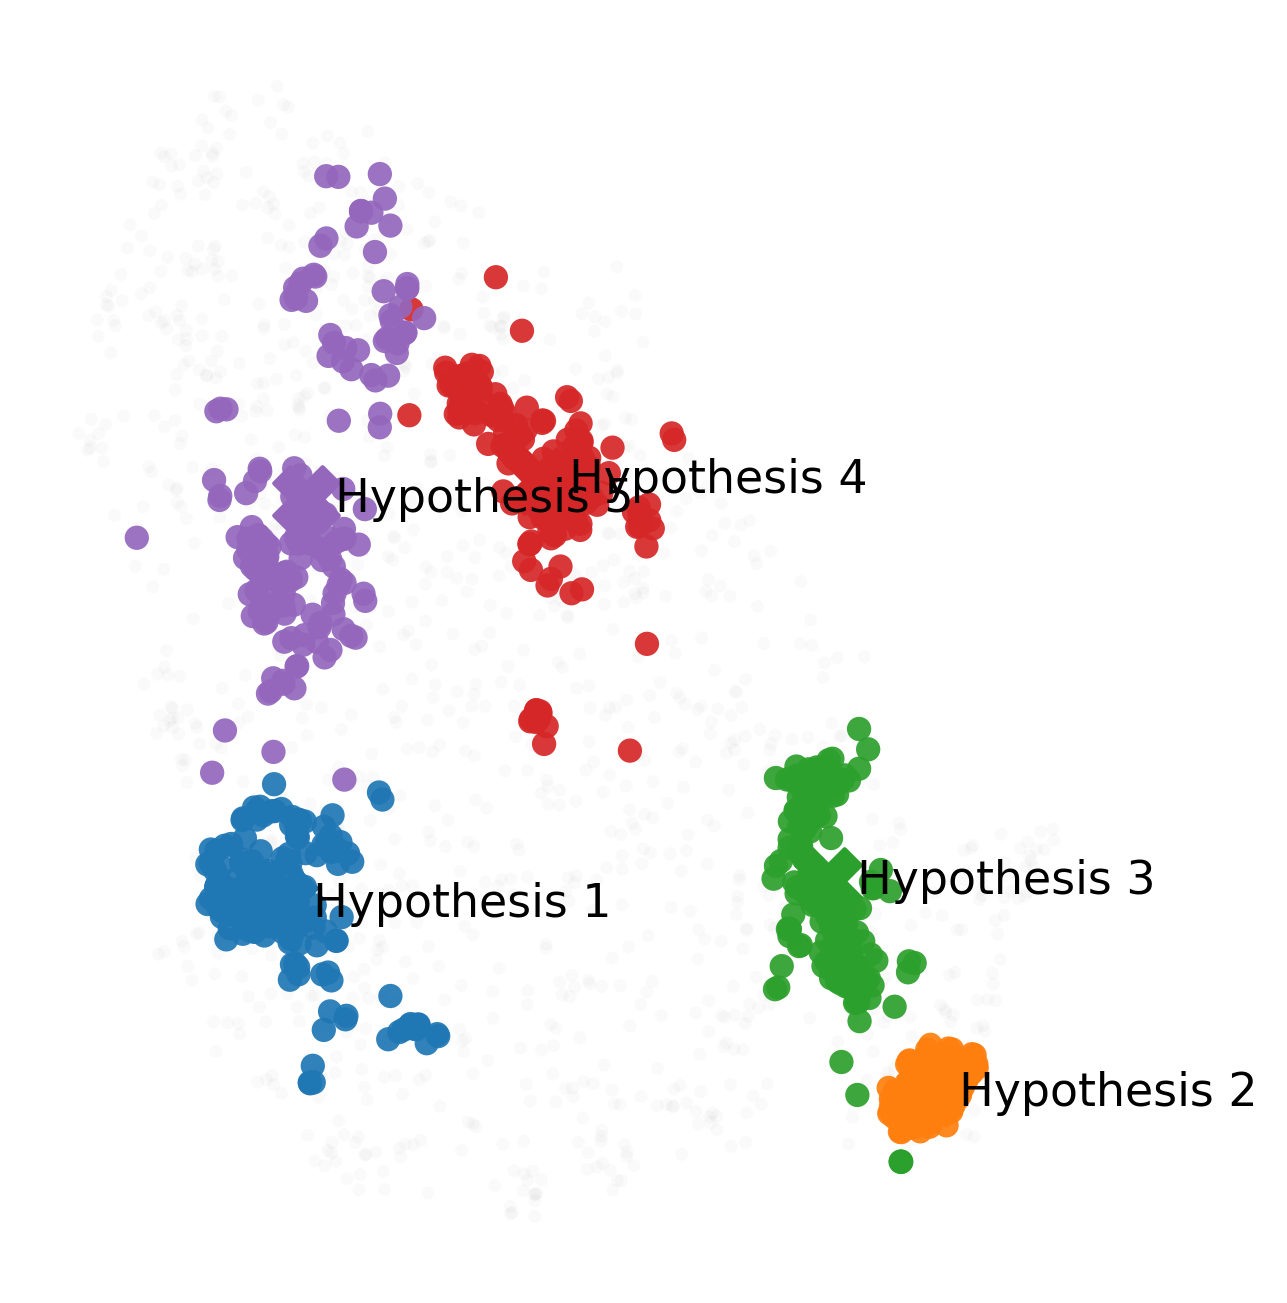

Exported: /home/hschatzle/monte-carlo-selection/notebooks/tsne_panelA_hypotheses.svg


In [79]:
# Step 3. Overlay selected BGMM components as clean islands labeled Hypothesis 1–5

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Requires:
#   Y    -> (nE,2) t-SNE coordinates
#   resp -> (nE,K) responsibilities

Y = np.asarray(Y, dtype=np.float64)
resp = np.asarray(resp, dtype=np.float64)
nE = Y.shape[0]

# -------- fixed illustrative components --------
ks = [4, 16, 41, 60, 23]

# Map to clean labels
label_map = {k: f"Hypothesis {i+1}" for i, k in enumerate(ks)}

print("Component → label mapping:")
for k in ks:
    print(k, "→", label_map[k])

# -------- visual style --------
FIG_W, FIG_H = 4.2, 4.2
DPI = 300

S_BG = 10
A_BG = 0.02
BG_N = 1200

S_FG = 34
A_FG = 0.92

OUT = Path("tsne_panelA_hypotheses.svg")

# -------- background subsample --------
rng = np.random.default_rng(0)
bg_idx = rng.choice(np.arange(nE), size=min(BG_N, nE), replace=False)

# -------- clean core selection --------
TAU = 0.60
MAX_PER = 180
MIN_PER = 40
FALLBACK_TOPN = 140

picked = {}
centroid = {}

for k in ks:
    rik = resp[:, k]
    idx = np.where(np.isfinite(rik))[0]

    sel = idx[rik[idx] >= TAU]

    if sel.size < MIN_PER:
        order = idx[np.argsort(rik[idx])[::-1]]
        sel = order[:min(FALLBACK_TOPN, order.size)]

    if sel.size > MAX_PER:
        order = sel[np.argsort(rik[sel])[::-1]]
        sel = order[:MAX_PER]

    picked[k] = sel
    centroid[k] = (float(np.mean(Y[sel, 0])), float(np.mean(Y[sel, 1])))

# -------- discrete clean colors --------
cmap = plt.get_cmap("tab10")
colors = {k: cmap(i % 10) for i, k in enumerate(ks)}

# -------- plot --------
fig, ax = plt.subplots(figsize=(FIG_W, FIG_H), dpi=DPI)

# background
ax.scatter(
    Y[bg_idx, 0], Y[bg_idx, 1],
    s=S_BG, alpha=A_BG,
    c="black", edgecolors="none"
)

# hypotheses
for k in ks:
    sel = picked[k]
    col = colors[k]

    ax.scatter(
        Y[sel, 0], Y[sel, 1],
        s=S_FG,
        alpha=A_FG,
        color=col,
        edgecolors="none"
    )

    # centroid marker
    cx, cy = centroid[k]
    ax.scatter([cx], [cy], s=240, marker="X", color=col)

    # label
    ax.text(cx, cy, f"  {label_map[k]}", fontsize=11, va="center")

# clean axes
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout(pad=0.2)

# export for Illustrator
fig.savefig(OUT, format="svg", bbox_inches="tight", pad_inches=0.02)
plt.show()

print("Exported:", OUT.resolve())


k -> label: {4: 'Hypothesis 1', 16: 'Hypothesis 2', 41: 'Hypothesis 3', 60: 'Hypothesis 4', 23: 'Hypothesis 5'}
NPZ keys: ['polygons', 'out_files', 'base_grid', 'matlab_1_indexed']
Inferred storage: object_array polygons


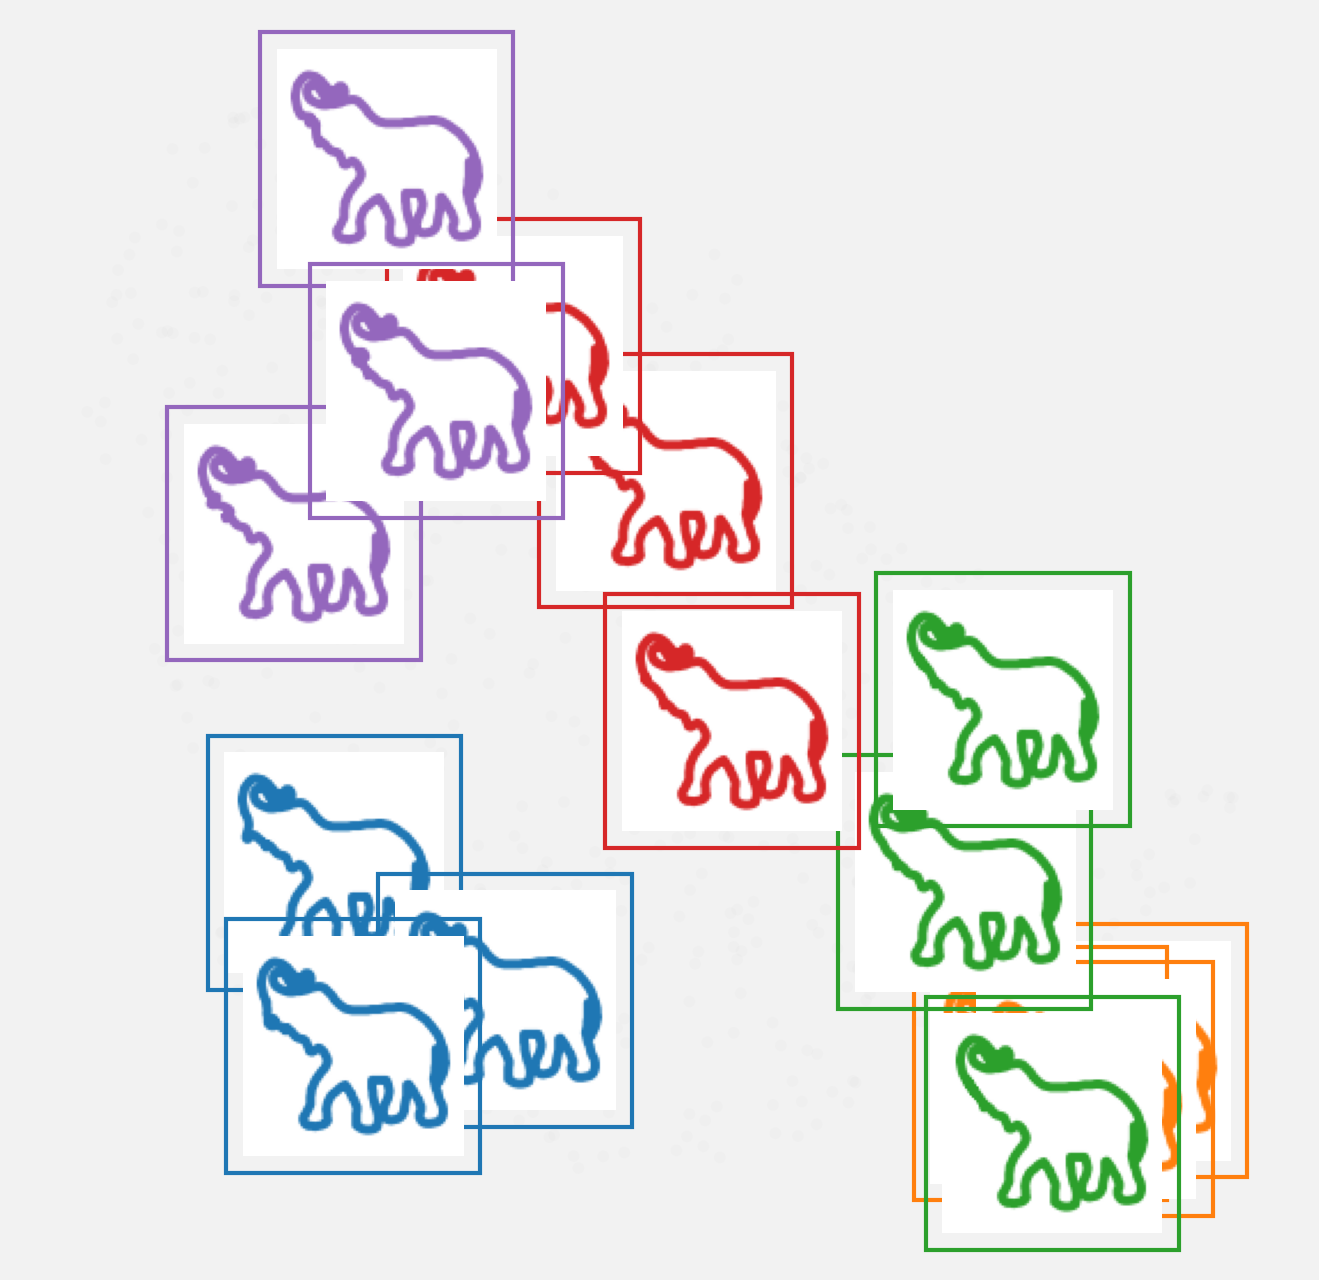

Exported: /home/hschatzle/monte-carlo-selection/notebooks/tsne_panelA_contours.svg
Total thumbnails: 15


In [21]:
# Panel v2: place CONTOUR-ONLY thumbnails (from shapes_xy.npz) at t-SNE coords, colored by hypothesis
# Requires: Y (nE,2), resp (nE,K), and (optionally) E_idx for mapping eligible->global indices.

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

NPZ_PATH = Path("/home/hschatzle/monte-carlo-selection/data/cases/elephant_7_val_6/generated/shapes_xy.npz")

Y = np.asarray(Y, dtype=np.float64)         # (nE,2)
resp = np.asarray(resp, dtype=np.float64)   # (nE,K)
nE = resp.shape[0]

# Choose hypotheses (same as before)
ks = [4, 16, 41, 60, 23]
label_map = {k: f"Hypothesis {i+1}" for i, k in enumerate(ks)}
print("k -> label:", {k: label_map[k] for k in ks})

# Control how many contour thumbnails
N_PER = 3               # 3 -> 15 total, 4 -> 20 total
POOL_TOPM = 120         # draw examples from top-M by responsibility to stay in the core
SPREAD_WITHIN = True    # pick diverse exemplars within each hypothesis (less overlap)

# Figure style
FIG_W, FIG_H = 4.2, 4.2
PANEL_GRAY = "#f2f2f2"
OUT = Path("tsne_panelA_contours.svg")

# Thumbnail style (contours only)
THUMB_PX = 96           # raster size of each contour stamp
LINE_W = 3.0            # contour linewidth (in thumbnail pixels, roughly)
PAD_FRAC = 0.10         # padding around contour in thumbnail
ALPHA_LINE = 1.0

# ------------------------------------------------------------
# 1) Load contours NPZ robustly
# ------------------------------------------------------------
if not NPZ_PATH.exists():
    raise FileNotFoundError(f"Missing NPZ: {NPZ_PATH}")

npz = np.load(NPZ_PATH, allow_pickle=True)
keys = list(npz.keys())
print("NPZ keys:", keys)

# Try common storage patterns:
# - single object array: xys (len N), each entry is (Ni,2)
# - arrays X and Y with padding/NaNs
# - dict-like with numbered keys
def _infer_store(npz):
    # object array candidates
    for k in ["xys", "xy", "shapes_xy", "contours", "polys", "polygons"]:
        if k in npz:
            arr = npz[k]
            return ("object_array", k, arr)

    # paired arrays candidates
    for kx, ky in [("xs", "ys"), ("X", "Y"), ("x", "y")]:
        if kx in npz and ky in npz:
            return ("xy_pair", (kx, ky), (npz[kx], npz[ky]))

    # numbered keys
    # e.g., "0","1",... or "shape_0",...
    numlike = []
    for k in keys:
        if k.isdigit():
            numlike.append(k)
    if len(numlike) > 0:
        return ("numbered", "digit_keys", None)

    pref = "shape_"
    prefkeys = [k for k in keys if k.startswith(pref)]
    if len(prefkeys) > 0:
        return ("numbered", pref, None)

    return ("unknown", None, None)

store_type, store_key, store_val = _infer_store(npz)
print("Inferred storage:", store_type, store_key)

def get_xy(global_i: int) -> np.ndarray:
    """Return Nx2 contour for completion index global_i."""
    if store_type == "object_array":
        arr = store_val
        xy = arr[int(global_i)]
        xy = np.asarray(xy, dtype=np.float64)
        if xy.ndim != 2 or xy.shape[1] != 2:
            raise ValueError(f"Entry {global_i} in {store_key} is not Nx2. Got {xy.shape}.")
        return xy

    if store_type == "xy_pair":
        xs, ys = store_val
        x = np.asarray(xs[int(global_i)], dtype=np.float64)
        y = np.asarray(ys[int(global_i)], dtype=np.float64)
        # handle NaN-padded sequences
        ok = np.isfinite(x) & np.isfinite(y)
        return np.stack([x[ok], y[ok]], axis=1)

    if store_type == "numbered":
        if store_key == "digit_keys":
            k = str(int(global_i))
            if k not in npz:
                raise KeyError(f"Key '{k}' not in NPZ.")
            xy = np.asarray(npz[k], dtype=np.float64)
            return xy
        else:
            k = f"{store_key}{int(global_i)}"
            if k not in npz:
                raise KeyError(f"Key '{k}' not in NPZ.")
            xy = np.asarray(npz[k], dtype=np.float64)
            return xy

    raise RuntimeError(
        "Could not infer contour storage from NPZ. "
        f"Keys={keys}. Please tell me what the keys look like."
    )

# ------------------------------------------------------------
# 2) Pick exemplars per hypothesis from responsibilities
# ------------------------------------------------------------
rng = np.random.default_rng(0)

def pick_js_for_k(k: int, Y: np.ndarray, resp: np.ndarray, n_pick: int, pool_topm: int, spread: bool):
    rik = resp[:, int(k)].astype(np.float64)
    idx = np.where(np.isfinite(rik))[0]
    if idx.size == 0:
        return np.array([], dtype=int)

    order = idx[np.argsort(rik[idx])[::-1]]
    pool = order[:min(pool_topm, order.size)]

    if pool.size <= n_pick or not spread:
        return pool[:min(n_pick, pool.size)]

    # Greedy farthest-point selection within pool in embedding space, seeded by best r_ik
    chosen = [int(pool[0])]
    while len(chosen) < n_pick:
        P = pool
        # distance to nearest chosen
        d2 = np.min([np.sum((Y[P] - Y[c])**2, axis=1) for c in chosen], axis=0)
        # avoid picking same point
        for c in chosen:
            d2[P == c] = -np.inf
        nxt = int(P[np.argmax(d2)])
        chosen.append(nxt)
    return np.array(chosen, dtype=int)

picked_j = {}
for k in ks:
    picked_j[k] = pick_js_for_k(k, Y, resp, n_pick=N_PER, pool_topm=POOL_TOPM, spread=SPREAD_WITHIN)

# eligible j -> global index mapping (for shapes_xy.npz indexing)
if "E_idx" in globals() and len(E_idx) == nE:
    E_idx_arr = np.asarray(E_idx, dtype=int)
    j_to_global = lambda j: int(E_idx_arr[int(j)])
else:
    j_to_global = lambda j: int(j)

# ------------------------------------------------------------
# 3) Render contour thumbnails (RGBA) and place at t-SNE coords
# ------------------------------------------------------------
def contour_rgba(xy: np.ndarray, rgb, px=96, lw=3.0, pad_frac=0.10):
    """Render contour-only RGBA stamp with transparent background."""
    xy = np.asarray(xy, dtype=np.float64)
    x, y = xy[:, 0], xy[:, 1]

    # normalize to square with padding
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    cx, cy = 0.5*(xmin+xmax), 0.5*(ymin+ymax)
    w, h = (xmax-xmin), (ymax-ymin)
    s = max(w, h) * (1.0 + 2.0*pad_frac) + 1e-12

    xn = (x - cx)/s + 0.5
    yn = (y - cy)/s + 0.5

    # rasterize into an RGBA array via a tiny Matplotlib figure
    fig = plt.figure(figsize=(1, 1), dpi=px)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_axis_off()
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    ax.plot(xn, yn, color=rgb, linewidth=lw, alpha=ALPHA_LINE)
    # close contour if not closed
    if np.hypot(xn[0]-xn[-1], yn[0]-yn[-1]) > 1e-3:
        ax.plot([xn[-1], xn[0]], [yn[-1], yn[0]], color=rgb, linewidth=lw, alpha=ALPHA_LINE)

    fig.canvas.draw()
    wpx, hpx = fig.canvas.get_width_height()
    img = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8).reshape(hpx, wpx, 4)
    plt.close(fig)

    # ARGB -> RGBA
    img = img[:, :, [1, 2, 3, 0]]
    return img

# color palette (discrete)
cmap = plt.get_cmap("tab10")
colors = {k: cmap(i % 10) for i, k in enumerate(ks)}

# main figure
fig, ax = plt.subplots(figsize=(FIG_W, FIG_H), dpi=300, facecolor=PANEL_GRAY)
ax.set_facecolor(PANEL_GRAY)

# (optional) very faint background points for context
# comment out if you want ultra-clean
BG_N = 600
bg_idx = rng.choice(np.arange(nE), size=min(BG_N, nE), replace=False)
ax.scatter(Y[bg_idx, 0], Y[bg_idx, 1], s=8, alpha=0.02, c="#7a7a7a", edgecolors="none")

# place contour stamps
for k in ks:
    col = colors[k]
    rgb = (col[0], col[1], col[2], 1.0)

    for j in picked_j[k]:
        gi = j_to_global(j)
        xy = get_xy(gi)

        stamp = contour_rgba(xy, rgb=rgb, px=THUMB_PX, lw=LINE_W, pad_frac=PAD_FRAC)

        oi = OffsetImage(stamp, zoom=0.55)  # tune zoom in Illustrator too, but this is a good start
        ab = AnnotationBbox(
            oi,
            (float(Y[j, 0]), float(Y[j, 1])),
            frameon=True,
            bboxprops=dict(edgecolor=rgb, linewidth=1.0, facecolor=(1, 1, 1, 0.0))
        )
        ax.add_artist(ab)

# clean axes
ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout(pad=0)
fig.savefig(OUT, format="svg", bbox_inches="tight", pad_inches=0, facecolor=PANEL_GRAY)
plt.show()

print("Exported:", OUT.resolve())
print("Total thumbnails:", sum(len(picked_j[k]) for k in ks))


Best flips: {'flip_x': False, 'flip_y': False}
picked: {4: 3, 16: 3, 41: 3, 60: 3, 23: 3}


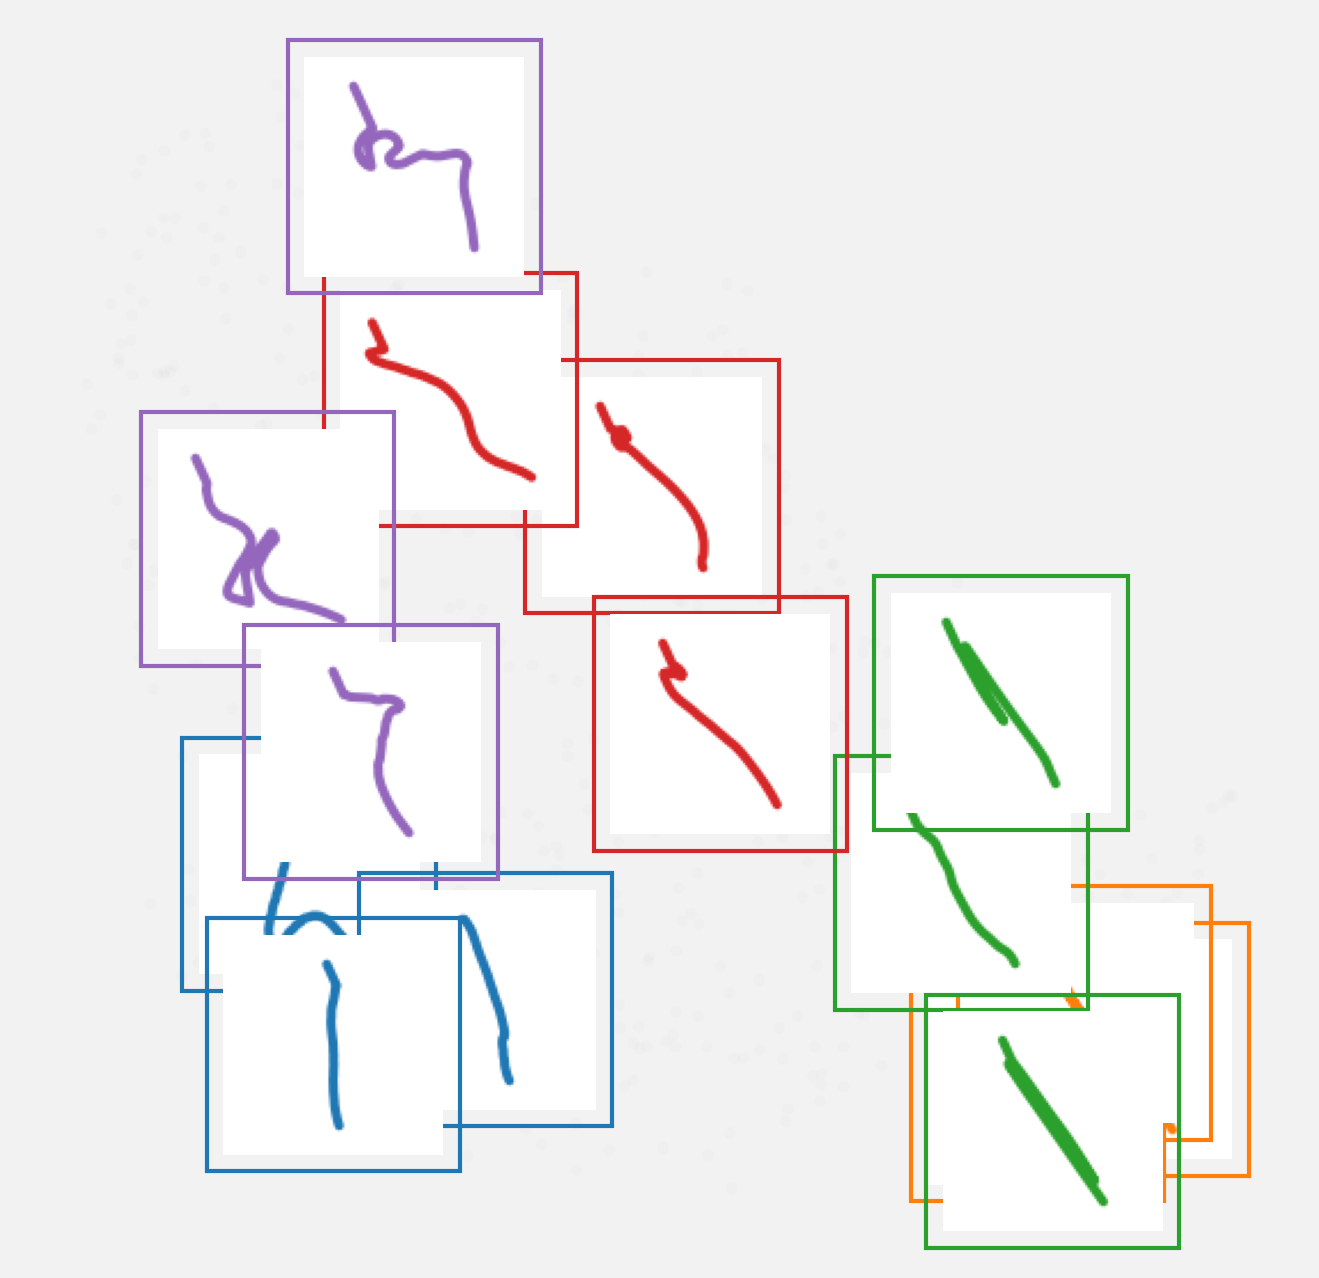

Exported: tsne_panelA_occludedContours.svg
Placed: 15 Skipped: 0


In [17]:
import json, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# ---------- paths ----------
NPZ_PATH  = Path("/home/hschatzle/monte-carlo-selection/data/cases/elephant_7_val_6/generated/shapes_xy.npz")
JSONL_PATH = Path("/home/hschatzle/monte-carlo-selection/data/cases/elephant_7_val_6/generated/elephant_7_val_6.jsonl")

# ---------- load ----------
npz = np.load(NPZ_PATH, allow_pickle=True)
polygons = npz["polygons"]

with JSONL_PATH.open("r") as f:
    rec = json.loads(f.readline())

R = np.asarray(rec["shape_contour_xy"], dtype=np.float64)
occ_rect  = np.asarray(rec["occluder_rect_xy"], dtype=np.float64)

# ---------- fit mapping (quantile affine + choose flips) ----------
FIT_I = 0
P_fit = np.asarray(polygons[FIT_I], dtype=np.float64)
qs = np.linspace(0.02, 0.98, 33)

def fit_affine_quantiles(u, v, qs):
    uq = np.quantile(u, qs)
    vq = np.quantile(v, qs)
    A = np.c_[uq, np.ones_like(uq)]
    a, b = np.linalg.lstsq(A, vq, rcond=None)[0]
    return float(a), float(b)

a_x, b_x = fit_affine_quantiles(P_fit[:,0], R[:,0], qs)
a_y, b_y = fit_affine_quantiles(P_fit[:,1], R[:,1], qs)

def apply_base_map(Pxy, flip_x=False, flip_y=False):
    Pxy = np.asarray(Pxy, dtype=np.float64)
    x = a_x*Pxy[:,0] + b_x
    y = a_y*Pxy[:,1] + b_y
    if flip_x: x = 1.0 - x
    if flip_y: y = 1.0 - y
    return np.stack([x, y], axis=1)

def score_variant(mapped_xy, ref_xy, qs):
    mxq = np.quantile(mapped_xy[:,0], qs); rxq = np.quantile(ref_xy[:,0], qs)
    myq = np.quantile(mapped_xy[:,1], qs); ryq = np.quantile(ref_xy[:,1], qs)
    return float(np.sqrt(np.mean((mxq-rxq)**2) + np.mean((myq-ryq)**2)))

best = None
for fx in [False, True]:
    for fy in [False, True]:
        M = apply_base_map(P_fit, fx, fy)
        s = score_variant(M, R, qs)
        if best is None or s < best[0]:
            best = (s, fx, fy)

_, flip_x_best, flip_y_best = best
print("Best flips:", {"flip_x": flip_x_best, "flip_y": flip_y_best})

# centroid+scale refinement relative to reference contour (keeps things consistent)
cR = R.mean(axis=0)
sR = np.sqrt(np.mean(np.sum((R - cR)**2, axis=1)))

def pixel_to_norm_refined_safe(Pxy):
    M = apply_base_map(Pxy, flip_x_best, flip_y_best)
    cM = M.mean(axis=0)
    sM = np.sqrt(np.mean(np.sum((M - cM)**2, axis=1)))
    M = (M - cM) * (sR / (sM + 1e-12)) + cR
    return M

# ---------- occluder segment extraction ----------
xminR, yminR = np.min(occ_rect, axis=0)
xmaxR, ymaxR = np.max(occ_rect, axis=0)

def segments_inside_rect(poly_norm):
    xy = np.asarray(poly_norm, dtype=np.float64)
    inside = (xy[:,0] >= xminR) & (xy[:,0] <= xmaxR) & (xy[:,1] >= yminR) & (xy[:,1] <= ymaxR)
    idx = np.where(inside)[0]
    if idx.size == 0:
        return []
    breaks = np.where(np.diff(idx) != 1)[0] + 1
    runs = np.split(idx, breaks)
    if inside[0] and inside[-1] and len(runs) >= 2:
        runs[0] = np.concatenate([runs[-1], runs[0]])
        runs = runs[:-1]
    return [xy[r] for r in runs if r.size >= 2]

# ---------- t-SNE snippet panel ----------
Y = np.asarray(Y, dtype=np.float64)
resp = np.asarray(resp, dtype=np.float64)
nE = resp.shape[0]

ks = [4, 16, 41, 60, 23]
N_PER = 3
POOL_TOPM = 160
SPREAD_WITHIN = True

FIG_W, FIG_H = 4.2, 4.2
PANEL_GRAY = "#f2f2f2"
OUT = "tsne_panelA_occludedContours.svg"

THUMB_PX = 96
LINE_W = 3.0
PAD_FRAC = 0.18
ZOOM = 0.55

rng = np.random.default_rng(0)

# eligible j -> global index
if "E_idx" in globals() and len(E_idx) == nE:
    E_idx_arr = np.asarray(E_idx, dtype=int)
    j_to_global = lambda j: int(E_idx_arr[int(j)])
else:
    j_to_global = lambda j: int(j)

def pick_js_for_k(k: int, n_pick: int):
    rik = resp[:, int(k)].astype(np.float64)
    idx = np.where(np.isfinite(rik))[0]
    if idx.size == 0:
        return np.array([], dtype=int)
    order = idx[np.argsort(rik[idx])[::-1]]
    pool = order[:min(POOL_TOPM, order.size)]
    if pool.size <= n_pick or not SPREAD_WITHIN:
        return pool[:min(n_pick, pool.size)]
    chosen = [int(pool[0])]
    while len(chosen) < n_pick:
        d2 = np.full(pool.shape[0], np.inf, dtype=np.float64)
        for c in chosen:
            d2 = np.minimum(d2, np.sum((Y[pool] - Y[c])**2, axis=1))
        for i, p in enumerate(pool):
            if int(p) in chosen:
                d2[i] = -np.inf
        chosen.append(int(pool[int(np.argmax(d2))]))
    return np.array(chosen, dtype=int)

cmap = plt.get_cmap("tab10")
colors = {k: cmap(i % 10) for i, k in enumerate(ks)}

def render_segment_rgba(seg_xy, rgb, px=96, lw=3.0, pad_frac=0.18):
    seg = np.asarray(seg_xy, dtype=np.float64)
    x, y = seg[:,0], seg[:,1]

    xmin, xmax = float(np.min(x)), float(np.max(x))
    ymin, ymax = float(np.min(y)), float(np.max(y))
    cx, cy = 0.5*(xmin+xmax), 0.5*(ymin+ymax)
    w, h = (xmax-xmin), (ymax-ymin)
    s = max(w, h) * (1.0 + 2.0*pad_frac) + 1e-12

    xn = (x - cx)/s + 0.5
    yn = (y - cy)/s + 0.5

    fig = plt.figure(figsize=(1,1), dpi=px)
    axes = fig.add_axes([0,0,1,1])
    axes.set_axis_off()
    axes.set_xlim(0,1); axes.set_ylim(0,1)
    axes.plot(xn, yn, color=rgb, linewidth=lw, solid_capstyle="round")
    fig.canvas.draw()

    wpx, hpx = fig.canvas.get_width_height()
    img = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8).reshape(hpx, wpx, 4)
    plt.close(fig)
    img = img[:, :, [1,2,3,0]]  # ARGB->RGBA
    return img

picked = {k: pick_js_for_k(k, N_PER) for k in ks}
print("picked:", {k: int(picked[k].size) for k in ks})

fig, axes = plt.subplots(figsize=(FIG_W, FIG_H), dpi=300, facecolor=PANEL_GRAY)
axes.set_facecolor(PANEL_GRAY)

# faint context points
BG_N = 500
bg_idx = rng.choice(np.arange(nE), size=min(BG_N, nE), replace=False)
axes.scatter(Y[bg_idx,0], Y[bg_idx,1], s=8, alpha=0.02, c="#7a7a7a", edgecolors="none")

placed = 0
skipped = 0

for k in ks:
    col = colors[k]
    rgb = (col[0], col[1], col[2], 1.0)

    for j in picked[k]:
        gi = j_to_global(j)

        poly_pix = np.asarray(polygons[gi], dtype=np.float64)
        poly_norm = pixel_to_norm_refined_safe(poly_pix)

        segs = segments_inside_rect(poly_norm)
        if len(segs) == 0:
            skipped += 1
            continue

        seg = max(segs, key=lambda s: s.shape[0])  # longest occluded segment
        stamp = render_segment_rgba(seg, rgb=rgb, px=THUMB_PX, lw=LINE_W, pad_frac=PAD_FRAC)

        oi = OffsetImage(stamp, zoom=ZOOM)
        ab = AnnotationBbox(
            oi, (float(Y[j,0]), float(Y[j,1])),
            frameon=True,
            bboxprops=dict(edgecolor=rgb, linewidth=1.0, facecolor=(1,1,1,0.0))
        )
        axes.add_artist(ab)
        placed += 1

axes.set_xticks([]); axes.set_yticks([])
for sp in axes.spines.values():
    sp.set_visible(False)

plt.tight_layout(pad=0)
fig.savefig(OUT, format="svg", bbox_inches="tight", pad_inches=0, facecolor=PANEL_GRAY)
plt.show()

print("Exported:", OUT)
print("Placed:", placed, "Skipped:", skipped)


picked counts: {4: 30, 16: 30, 41: 30, 60: 30, 23: 30}


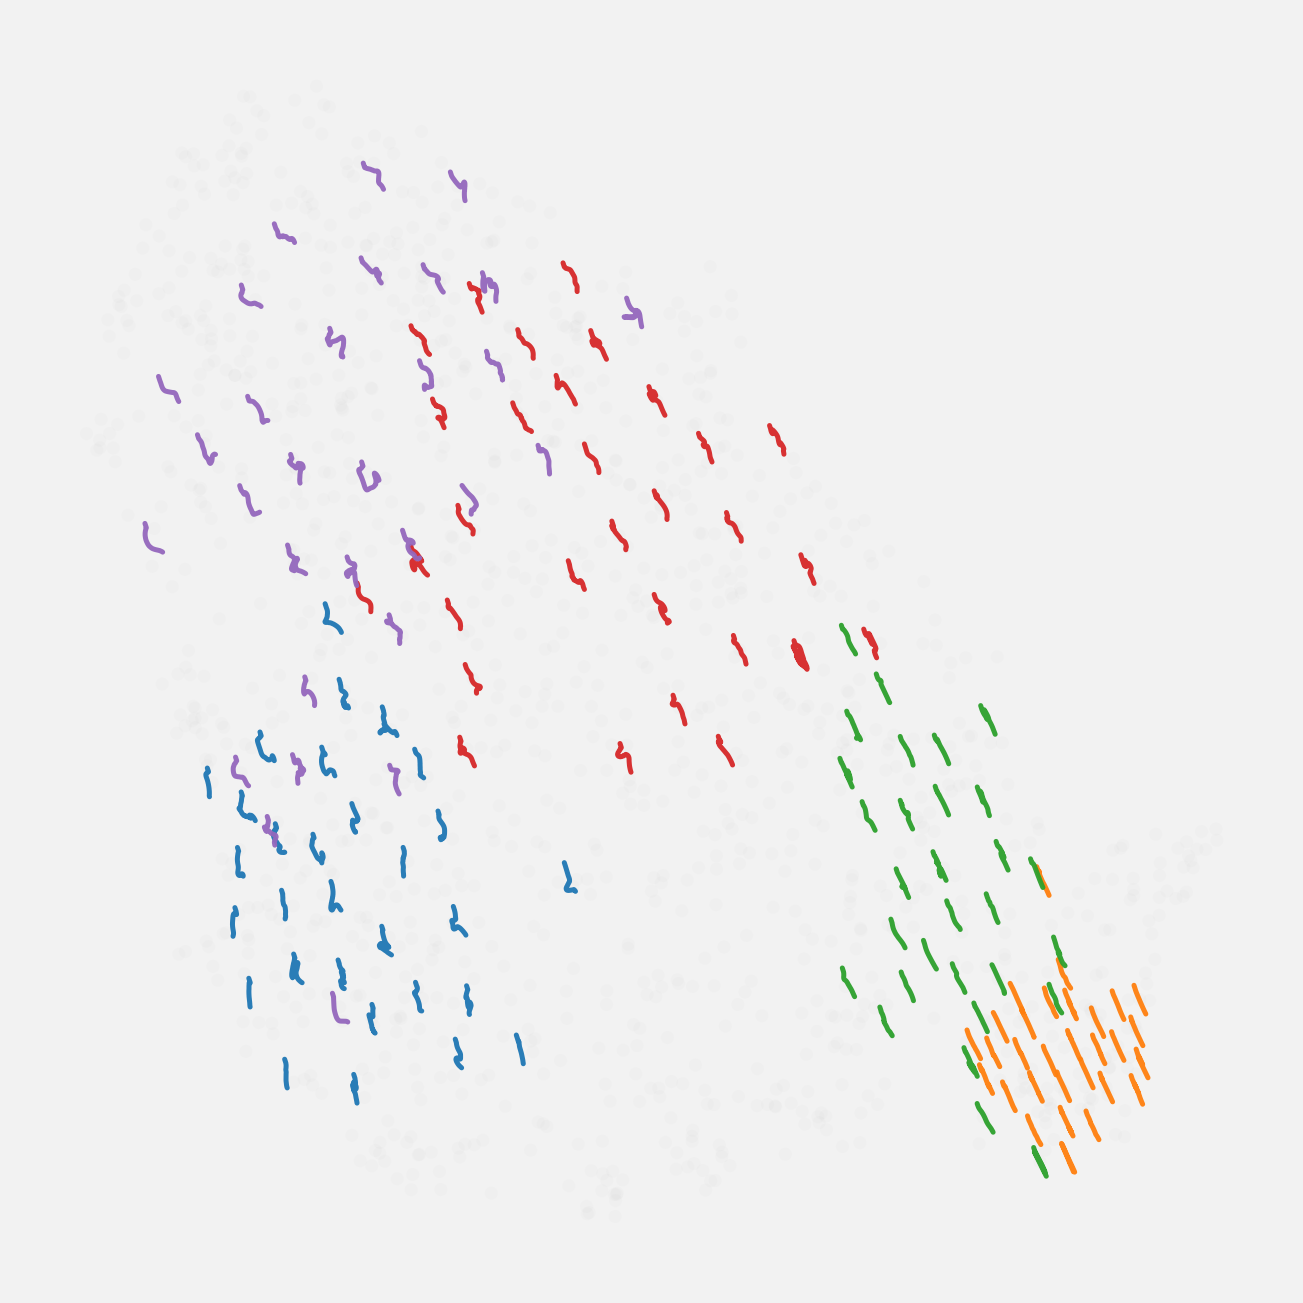

Exported: /home/hschatzle/monte-carlo-selection/notebooks/tsne_panelA_contours_tiny.svg
Placed: 150 segments, skipped: 0 (no occluder segment).
Background: plotted 1200 / 10000 points (alpha=0.02, size=10).


In [32]:
# Step 2 (Contours-only version). Tiny polylines, no thumbnails, no boxes.

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------ inputs ------------------
Y = np.asarray(Y, dtype=np.float64)
resp = np.asarray(resp, dtype=np.float64)
nE = Y.shape[0]

ks = [4, 16, 41, 60, 23]

N_PER = 30
POOL_TOPM = 400
SPREAD_WITHIN = True

# ------------------ style ------------------
FIG_W, FIG_H = 4.2, 4.2
DPI = 300
PANEL_GRAY = "#f2f2f2"

S_BG = 10
A_BG = 0.02
BG_N = 1200
BG_COL = "#7a7a7a"

# tiny contour drawing in embedding space
LINE_W = 1.2         # smaller than before
ALPHA_SEG = 0.95
SEG_SIZE_FRAC = 0.025  # relative to embedding span. smaller = tinier

OUT = Path("tsne_panelA_contours_tiny.svg")
rng = np.random.default_rng(0)

# eligible j -> global index for polygons
if "E_idx" in globals() and len(E_idx) == nE:
    E_idx_arr = np.asarray(E_idx, dtype=int)
    j_to_global = lambda j: int(E_idx_arr[int(j)])
else:
    j_to_global = lambda j: int(j)

# ------------------ background subsample ------------------
bg_idx = rng.choice(np.arange(nE), size=min(BG_N, nE), replace=False)

# ------------------ pick exemplars per component ------------------
def pick_js_for_k(k: int, n_pick: int):
    rik = resp[:, int(k)].astype(np.float64)
    idx = np.where(np.isfinite(rik))[0]
    if idx.size == 0:
        return np.array([], dtype=int)

    order = idx[np.argsort(rik[idx])[::-1]]
    pool = order[:min(POOL_TOPM, order.size)]
    if pool.size <= n_pick:
        return pool[:pool.size]
    if not SPREAD_WITHIN:
        return pool[:n_pick]

    chosen = [int(pool[0])]
    while len(chosen) < n_pick:
        d2 = np.full(pool.shape[0], np.inf, dtype=np.float64)
        for c in chosen:
            d2 = np.minimum(d2, np.sum((Y[pool] - Y[c])**2, axis=1))
        for i, p in enumerate(pool):
            if int(p) in chosen:
                d2[i] = -np.inf
        chosen.append(int(pool[int(np.argmax(d2))]))
    return np.array(chosen, dtype=int)

picked = {k: pick_js_for_k(k, N_PER) for k in ks}
print("picked counts:", {k: int(picked[k].size) for k in ks})

# ------------------ discrete colors ------------------
cmap = plt.get_cmap("tab10")
colors = {k: cmap(i % 10) for i, k in enumerate(ks)}

# ------------------ helper: draw segment as tiny polyline at embedding point ------------------
def draw_segment_at_point(ax, seg_xy_norm, x0, y0, color, size):
    seg = np.asarray(seg_xy_norm, dtype=np.float64)

    x, y = seg[:, 0], seg[:, 1]
    xmin, xmax = float(np.min(x)), float(np.max(x))
    ymin, ymax = float(np.min(y)), float(np.max(y))
    cx, cy = 0.5 * (xmin + xmax), 0.5 * (ymin + ymax)
    w, h = (xmax - xmin), (ymax - ymin)
    s = max(w, h) + 1e-12

    # center + isotropically scale to unit box, then to 'size' in embedding coordinates
    xs = (x - cx) / s
    ys = (y - cy) / s

    ax.plot(
        x0 + xs * size,
        y0 + ys * size,
        color=color,
        linewidth=LINE_W,
        alpha=ALPHA_SEG,
        solid_capstyle="round",
        solid_joinstyle="round",
        zorder=5,
    )

# ------------------ plot ------------------
fig, ax = plt.subplots(figsize=(FIG_W, FIG_H), dpi=DPI, facecolor=PANEL_GRAY)
ax.set_facecolor(PANEL_GRAY)

# background cloud
ax.scatter(
    Y[bg_idx, 0], Y[bg_idx, 1],
    s=S_BG, alpha=A_BG, c=BG_COL,
    marker="o", edgecolors="none", linewidths=0
)

# choose a physical size for snippets based on embedding span
xspan = float(np.max(Y[:, 0]) - np.min(Y[:, 0]) + 1e-12)
yspan = float(np.max(Y[:, 1]) - np.min(Y[:, 1]) + 1e-12)
snippet_size = SEG_SIZE_FRAC * min(xspan, yspan)

placed = 0
skipped = 0

for k in ks:
    col = colors[k]
    rgb = (col[0], col[1], col[2], 1.0)

    for j in picked[k]:
        gi = j_to_global(j)

        poly_pix = np.asarray(polygons[gi], dtype=np.float64)
        poly_norm = pixel_to_norm_refined_safe(poly_pix)

        segs = segments_inside_rect(poly_norm)
        if len(segs) == 0:
            skipped += 1
            continue

        seg = max(segs, key=lambda s: s.shape[0])  # longest occluded segment
        draw_segment_at_point(ax, seg, float(Y[j, 0]), float(Y[j, 1]), rgb, snippet_size)
        placed += 1

# clean axes
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout(pad=0.2)

fig.savefig(OUT, format="svg", bbox_inches="tight", pad_inches=0.02, facecolor=PANEL_GRAY)
plt.show()

print("Exported:", OUT.resolve())
print(f"Placed: {placed} segments, skipped: {skipped} (no occluder segment).")
print(f"Background: plotted {len(bg_idx)} / {nE} points (alpha={A_BG}, size={S_BG}).")


In [35]:
# Render ONE occluded-contour segment per figure.
# For k ∈ {4,16,23}, pick 2 samples → 6 separate panels total.
#
# Assumes in workspace:
#   Y (nE,2), resp (nE,K), polygons
#   pixel_to_norm_refined_safe(), segments_inside_rect()
# Optional:
#   E_idx (len nE) if resp rows index a subset of polygons

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

Y = np.asarray(Y, dtype=np.float64)
resp = np.asarray(resp, dtype=np.float64)
nE = Y.shape[0]

ks = [4, 16, 23]
N_SAMPLES = 2
POOL_TOPM = 400
SPREAD_WITHIN = True

LINE_W = 2.4
PAD = 0.20

OUT_DIR = Path("cluster_contours_single")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ------------------ index mapping ------------------
if "E_idx" in globals() and len(E_idx) == nE:
    E_idx_arr = np.asarray(E_idx, dtype=int)
    j_to_global = lambda j: int(E_idx_arr[int(j)])
else:
    j_to_global = lambda j: int(j)

# ------------------ selection ------------------
def pick_js_for_k(k: int, n_pick: int):
    rik = resp[:, int(k)].astype(np.float64)
    idx = np.where(np.isfinite(rik))[0]
    if idx.size == 0:
        return np.array([], dtype=int)

    order = idx[np.argsort(rik[idx])[::-1]]
    pool = order[:min(POOL_TOPM, order.size)]

    if pool.size <= n_pick:
        return pool[:pool.size]

    if not SPREAD_WITHIN:
        return pool[:n_pick]

    chosen = [int(pool[0])]
    while len(chosen) < n_pick:
        d2 = np.full(pool.shape[0], np.inf)
        for c in chosen:
            d2 = np.minimum(d2, np.sum((Y[pool] - Y[c]) ** 2, axis=1))
        for i, p in enumerate(pool):
            if int(p) in chosen:
                d2[i] = -np.inf
        chosen.append(int(pool[np.argmax(d2)]))
    return np.array(chosen, dtype=int)

# ------------------ segment extraction ------------------
def longest_occluded_segment(j: int):
    gi = j_to_global(j)
    poly_pix = np.asarray(polygons[gi], dtype=np.float64)
    poly_norm = pixel_to_norm_refined_safe(poly_pix)
    segs = segments_inside_rect(poly_norm)
    if not segs:
        return None
    return max(segs, key=lambda s: s.shape[0])

def normalize_to_panel(seg_xy, pad=0.2):
    seg = np.asarray(seg_xy, dtype=np.float64)
    x, y = seg[:, 0], seg[:, 1]
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    cx, cy = 0.5 * (xmin + xmax), 0.5 * (ymin + ymax)
    s = max(xmax - xmin, ymax - ymin) * (1 + 2 * pad) + 1e-12
    xn = (x - cx) / s + 0.5
    yn = (y - cy) / s + 0.5
    return xn, yn

# ------------------ colors ------------------
cmap = plt.get_cmap("tab10")
colors = {k: cmap(i % 10) for i, k in enumerate(ks)}

# ------------------ render ------------------
for k in ks:
    js = pick_js_for_k(k, N_SAMPLES)
    col = colors[k]
    rgb = (col[0], col[1], col[2], 1.0)

    for idx, j in enumerate(js):
        seg = longest_occluded_segment(int(j))
        if seg is None:
            continue

        xn, yn = normalize_to_panel(seg, pad=PAD)

        fig, ax = plt.subplots(
            figsize=(4.6, 2.6),  # rectangular, Nature-style
            dpi=300,
            facecolor="white"
        )
        ax.set_facecolor("white")

        ax.plot(
            xn, yn,
            color=rgb,
            linewidth=LINE_W,
            solid_capstyle="round",
            solid_joinstyle="round"
        )

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_aspect("equal", adjustable="box")
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

        plt.tight_layout(pad=0.15)

        out_svg = OUT_DIR / f"k{k}_sample{idx+1}.svg"
        out_png = OUT_DIR / f"k{k}_sample{idx+1}.png"
        fig.savefig(out_svg, format="svg", bbox_inches="tight", pad_inches=0.02)
        fig.savefig(out_png, bbox_inches="tight", pad_inches=0.02)
        plt.close(fig)

        print(f"Saved {out_svg}")


Saved cluster_contours_single/k4_sample1.svg
Saved cluster_contours_single/k4_sample2.svg
Saved cluster_contours_single/k16_sample1.svg
Saved cluster_contours_single/k16_sample2.svg
Saved cluster_contours_single/k23_sample1.svg
Saved cluster_contours_single/k23_sample2.svg


In [18]:
# Cell: Rebuild picked[k] so each k has >= 10 candidates
import numpy as np

resp = np.asarray(resp, dtype=np.float64)
nE = resp.shape[0]

ks = [4, 16, 41, 60, 23]

TAU = 0.60          # 0.6–0.8 gives “core”. 1.0 is basically never hit.
MAX_PER = 180       # cap size of each core
MIN_PER = 40        # ensure enough candidates
FALLBACK_TOPN = 140 # if TAU yields too few

picked = {}
picked_r = {}

for k in ks:
    rik = resp[:, int(k)].astype(np.float64)
    idx = np.where(np.isfinite(rik))[0]
    if idx.size == 0:
        picked[k] = np.array([], dtype=int)
        picked_r[k] = np.array([], dtype=np.float64)
        continue

    sel = idx[rik[idx] >= TAU]

    # ensure minimum size via top-N fallback
    if sel.size < MIN_PER:
        order = idx[np.argsort(rik[idx])[::-1]]
        sel = order[:min(FALLBACK_TOPN, order.size)]

    # cap to MAX_PER by responsibility
    if sel.size > MAX_PER:
        order = sel[np.argsort(rik[sel])[::-1]]
        sel = order[:MAX_PER]

    picked[k] = sel
    picked_r[k] = rik[sel]

print("picked sizes:", {k: int(picked[k].size) for k in ks})
for k in ks:
    r = picked_r[k]
    if r.size:
        print(f"k={k}: r_ik min/med/max = {float(r.min()):.3f} / {float(np.median(r)):.3f} / {float(r.max()):.3f}")


picked sizes: {4: 180, 16: 180, 41: 180, 60: 180, 23: 180}
k=4: r_ik min/med/max = 0.991 / 0.999 / 1.000
k=16: r_ik min/med/max = 1.000 / 1.000 / 1.000
k=41: r_ik min/med/max = 0.999 / 1.000 / 1.000
k=60: r_ik min/med/max = 0.997 / 1.000 / 1.000
k=23: r_ik min/med/max = 1.000 / 1.000 / 1.000


Exemplars per k: {4: 180, 16: 180, 41: 180, 60: 180, 23: 180}

Chamfer summary (lower = more similar)
within:  n= 1500  mean= 0.03321557570094018  median= 0.035501551258454014
between: n= 4500  mean= 0.04000345916057736  median= 0.04008602504098835


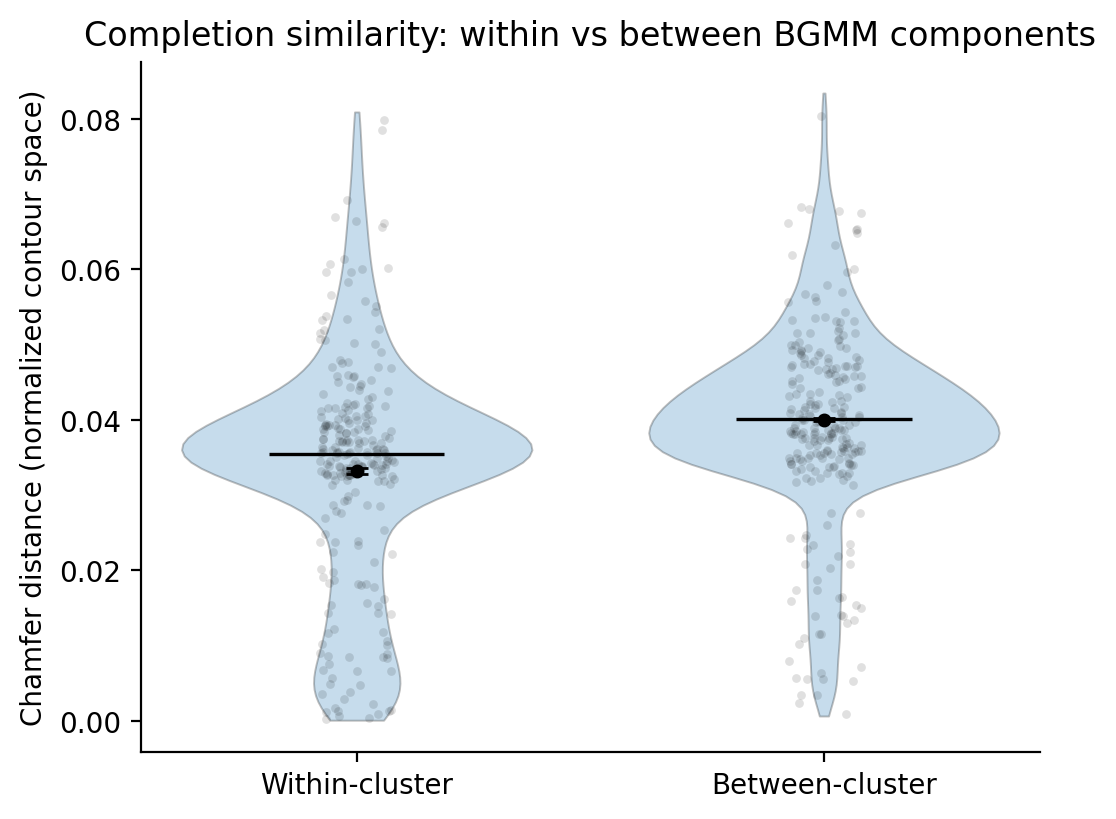

In [29]:
# Cell: Within- vs Between-cluster similarity (Chamfer) for illustrative BGMM components
# Requires:
#   - ks (list of components)
#   - picked (dict k -> array of eligible indices j)
#   - resp (nE,K) just for having picked from earlier (not used here)
#   - polygons (object array of contours, length N_total or nE)
# Optional:
#   - E_idx (len nE) mapping eligible j -> global index in polygons
#   - pixel_to_norm_refined_safe() mapping pixel contour -> normalized contour (recommended)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from itertools import combinations

# ---------------- params ----------------
M_PER_CLUSTER = 180       # how many shapes sampled per cluster
N_PTS = 220              # resample contour to fixed number of points for stable chamfer
MAX_WITHIN_PAIRS = 300   # cap pairs per cluster (speed)
MAX_BETWEEN_PAIRS = 450  # cap pairs per cluster-pair (speed)
RNG_SEED = 0

# ---------------- helpers ----------------
rng = np.random.default_rng(RNG_SEED)

def j_to_global(j, nE):
    if "E_idx" in globals() and len(E_idx) == nE:
        return int(np.asarray(E_idx, dtype=int)[int(j)])
    return int(j)

def resample_closed_poly(xy, n_pts=220):
    """Arc-length resample of a closed polygon/polyline to n_pts points."""
    xy = np.asarray(xy, dtype=np.float64)
    if xy.shape[0] < 5:
        return xy

    # ensure closed
    if np.linalg.norm(xy[0] - xy[-1]) > 1e-9:
        xy = np.vstack([xy, xy[0]])

    d = np.sqrt(np.sum(np.diff(xy, axis=0)**2, axis=1))
    s = np.r_[0.0, np.cumsum(d)]
    L = s[-1]
    if L < 1e-12:
        return xy[:1].repeat(n_pts, axis=0)

    t = np.linspace(0.0, L, n_pts, endpoint=False)
    x = np.interp(t, s, xy[:, 0])
    y = np.interp(t, s, xy[:, 1])
    return np.stack([x, y], axis=1)

def normalize_xy(xy):
    """Remove translation + scale (RMS). Keeps shape, removes size effects."""
    xy = np.asarray(xy, dtype=np.float64)
    c = xy.mean(axis=0)
    z = xy - c
    s = np.sqrt(np.mean(np.sum(z*z, axis=1))) + 1e-12
    return z / s

def to_xy_for_chamfer(global_i):
    """Get contour in a common space for chamfer."""
    poly_pix = np.asarray(polygons[int(global_i)], dtype=np.float64)
    if "pixel_to_norm_refined_safe" in globals():
        xy = pixel_to_norm_refined_safe(poly_pix)
    else:
        xy = poly_pix
    xy = resample_closed_poly(xy, n_pts=N_PTS)
    xy = normalize_xy(xy)
    return xy

def chamfer(xyA, xyB):
    """Symmetric Chamfer: mean NN(A->B) + mean NN(B->A)."""
    A = np.asarray(xyA, dtype=np.float64)
    B = np.asarray(xyB, dtype=np.float64)

    nnB = NearestNeighbors(n_neighbors=1, algorithm="auto").fit(B)
    dA, _ = nnB.kneighbors(A, return_distance=True)

    nnA = NearestNeighbors(n_neighbors=1, algorithm="auto").fit(A)
    dB, _ = nnA.kneighbors(B, return_distance=True)

    return float(dA.mean() + dB.mean())

def sample_indices(arr, m):
    arr = np.asarray(arr, dtype=int)
    if arr.size <= m:
        return arr
    return rng.choice(arr, size=m, replace=False)

# ---------------- collect exemplars per cluster ----------------
nE = int(resp.shape[0]) if "resp" in globals() else int(Y.shape[0])
exemplars = {}

for k in ks:
    sel = np.asarray(picked[k], dtype=int)
    if sel.size == 0:
        exemplars[k] = np.array([], dtype=int)
        continue
    j_s = sample_indices(sel, M_PER_CLUSTER)
    g_s = np.array([j_to_global(j, nE) for j in j_s], dtype=int)
    exemplars[k] = g_s

print("Exemplars per k:", {k: int(exemplars[k].size) for k in ks})

# precompute XY for all exemplars (big speedup)
xy_cache = {}
for k in ks:
    for gi in exemplars[k]:
        if gi not in xy_cache:
            xy_cache[gi] = to_xy_for_chamfer(gi)

# ---------------- compute within / between distributions ----------------
within = []
within_meta = []   # (k, i, j)

for k in ks:
    g = exemplars[k]
    if g.size < 2:
        continue
    pairs = list(combinations(g.tolist(), 2))
    if len(pairs) > MAX_WITHIN_PAIRS:
        pairs = rng.choice(pairs, size=MAX_WITHIN_PAIRS, replace=False).tolist()
    for a, b in pairs:
        within.append(chamfer(xy_cache[a], xy_cache[b]))
        within_meta.append((k, a, b))

between = []
between_meta = []  # ((k1,k2), i, j)

for k1, k2 in combinations(ks, 2):
    g1, g2 = exemplars[k1], exemplars[k2]
    if g1.size == 0 or g2.size == 0:
        continue
    # sample pairings without full Cartesian blow-up
    all_pairs = [(int(a), int(b)) for a in g1 for b in g2]
    if len(all_pairs) > MAX_BETWEEN_PAIRS:
        all_pairs = rng.choice(all_pairs, size=MAX_BETWEEN_PAIRS, replace=False).tolist()
    for a, b in all_pairs:
        between.append(chamfer(xy_cache[a], xy_cache[b]))
        between_meta.append(((k1, k2), a, b))

within = np.asarray(within, dtype=np.float64)
between = np.asarray(between, dtype=np.float64)

print("\nChamfer summary (lower = more similar)")
print("within:  n=", within.size, " mean=", float(np.mean(within)), " median=", float(np.median(within)))
print("between: n=", between.size, " mean=", float(np.mean(between)), " median=", float(np.median(between)))

# ---------------- plot: violin + mean±SEM ----------------
fig, axes = plt.subplots(figsize=(5.4, 4.2), dpi=200)

data = [within, between]
pos = [1, 2]

vp = axes.violinplot(data, positions=pos, widths=0.75, showmeans=False, showmedians=True, showextrema=False)

# clean violin style (no seaborn)
for body in vp["bodies"]:
    body.set_alpha(0.25)
    body.set_edgecolor("black")
    body.set_linewidth(0.7)

vp["cmedians"].set_color("black")
vp["cmedians"].set_linewidth(1.2)

# overlay mean±SEM as bars
means = [float(np.mean(within)), float(np.mean(between))]
sems  = [float(np.std(within, ddof=1) / np.sqrt(max(1, within.size))),
         float(np.std(between, ddof=1) / np.sqrt(max(1, between.size)))]

axes.errorbar(pos, means, yerr=sems, fmt="o", color="black", capsize=4, markersize=4, linewidth=1.2, zorder=5)

# light jittered points (subsample for readability)
def jitter(x, n, width=0.08):
    return x + rng.uniform(-width, width, size=n)

N_SCAT = 250
if within.size > 0:
    w_s = rng.choice(within, size=min(N_SCAT, within.size), replace=False)
    axes.scatter(jitter(1, w_s.size), w_s, s=10, alpha=0.12, color="black", linewidths=0)
if between.size > 0:
    b_s = rng.choice(between, size=min(N_SCAT, between.size), replace=False)
    axes.scatter(jitter(2, b_s.size), b_s, s=10, alpha=0.12, color="black", linewidths=0)

axes.set_xticks(pos)
axes.set_xticklabels(["Within-cluster", "Between-cluster"])
axes.set_ylabel("Chamfer distance (normalized contour space)")
axes.set_title("Completion similarity: within vs between BGMM components")

# minimal axes
axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


Exemplars per k: {4: 50, 16: 50, 41: 50, 60: 50, 23: 50}

--- Within (by k) ---
k=4: n=350 mean=0.03213 median=0.03476
k=16: n=350 mean=0.02787 median=0.0316
k=41: n=350 mean=0.02816 median=0.03314
k=60: n=350 mean=0.03354 median=0.03515
k=23: n=350 mean=0.03837 median=0.0386

--- Between (by pair) ---
4-16: n=450 mean=0.04315 median=0.04277
4-41: n=450 mean=0.04362 median=0.04303
4-60: n=450 mean=0.04017 median=0.04111
4-23: n=450 mean=0.03928 median=0.04021
16-41: n=450 mean=0.03061 median=0.03366
16-60: n=450 mean=0.03702 median=0.03654
16-23: n=450 mean=0.04426 median=0.04245
41-60: n=450 mean=0.03716 median=0.03615
41-23: n=450 mean=0.04384 median=0.04234
60-23: n=450 mean=0.03929 median=0.03912


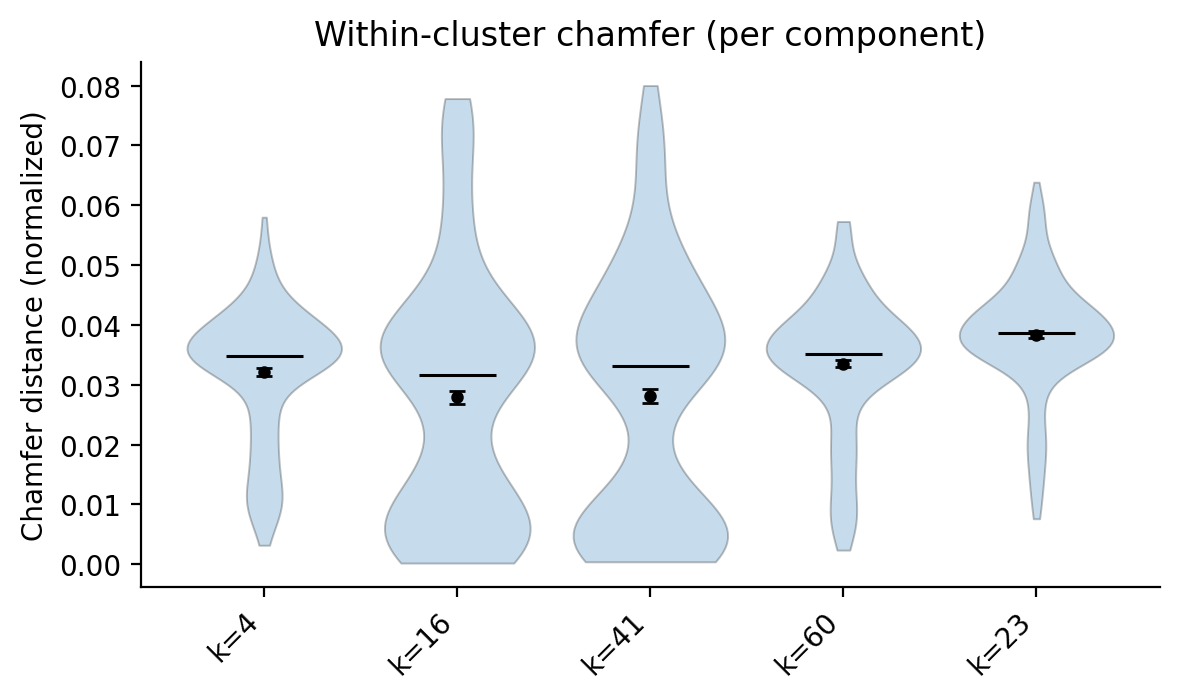

Saved: /home/hschatzle/monte-carlo-selection/results/chamfer_within_by_k.svg


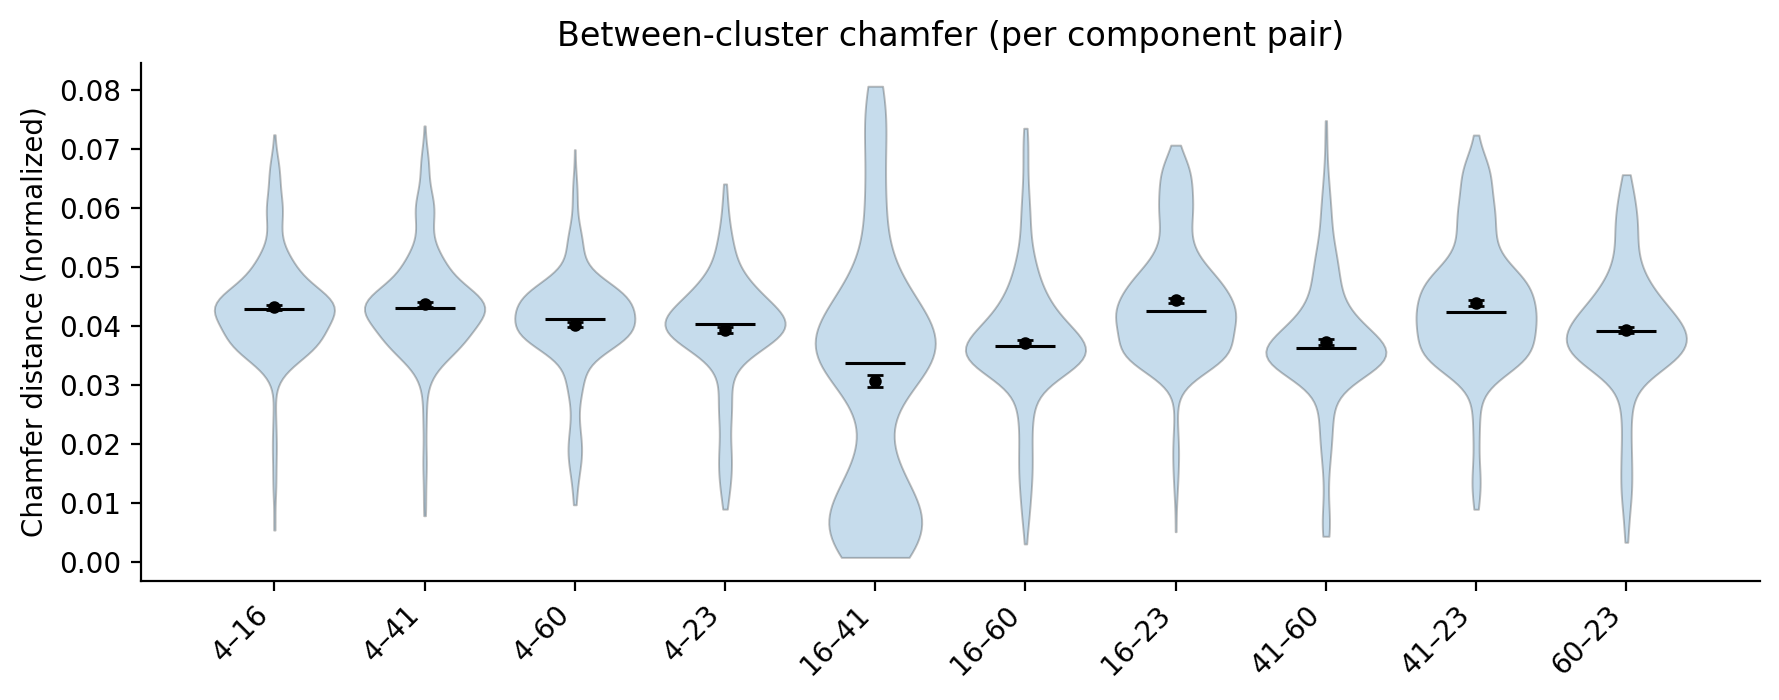

Saved: /home/hschatzle/monte-carlo-selection/results/chamfer_between_by_pair.svg


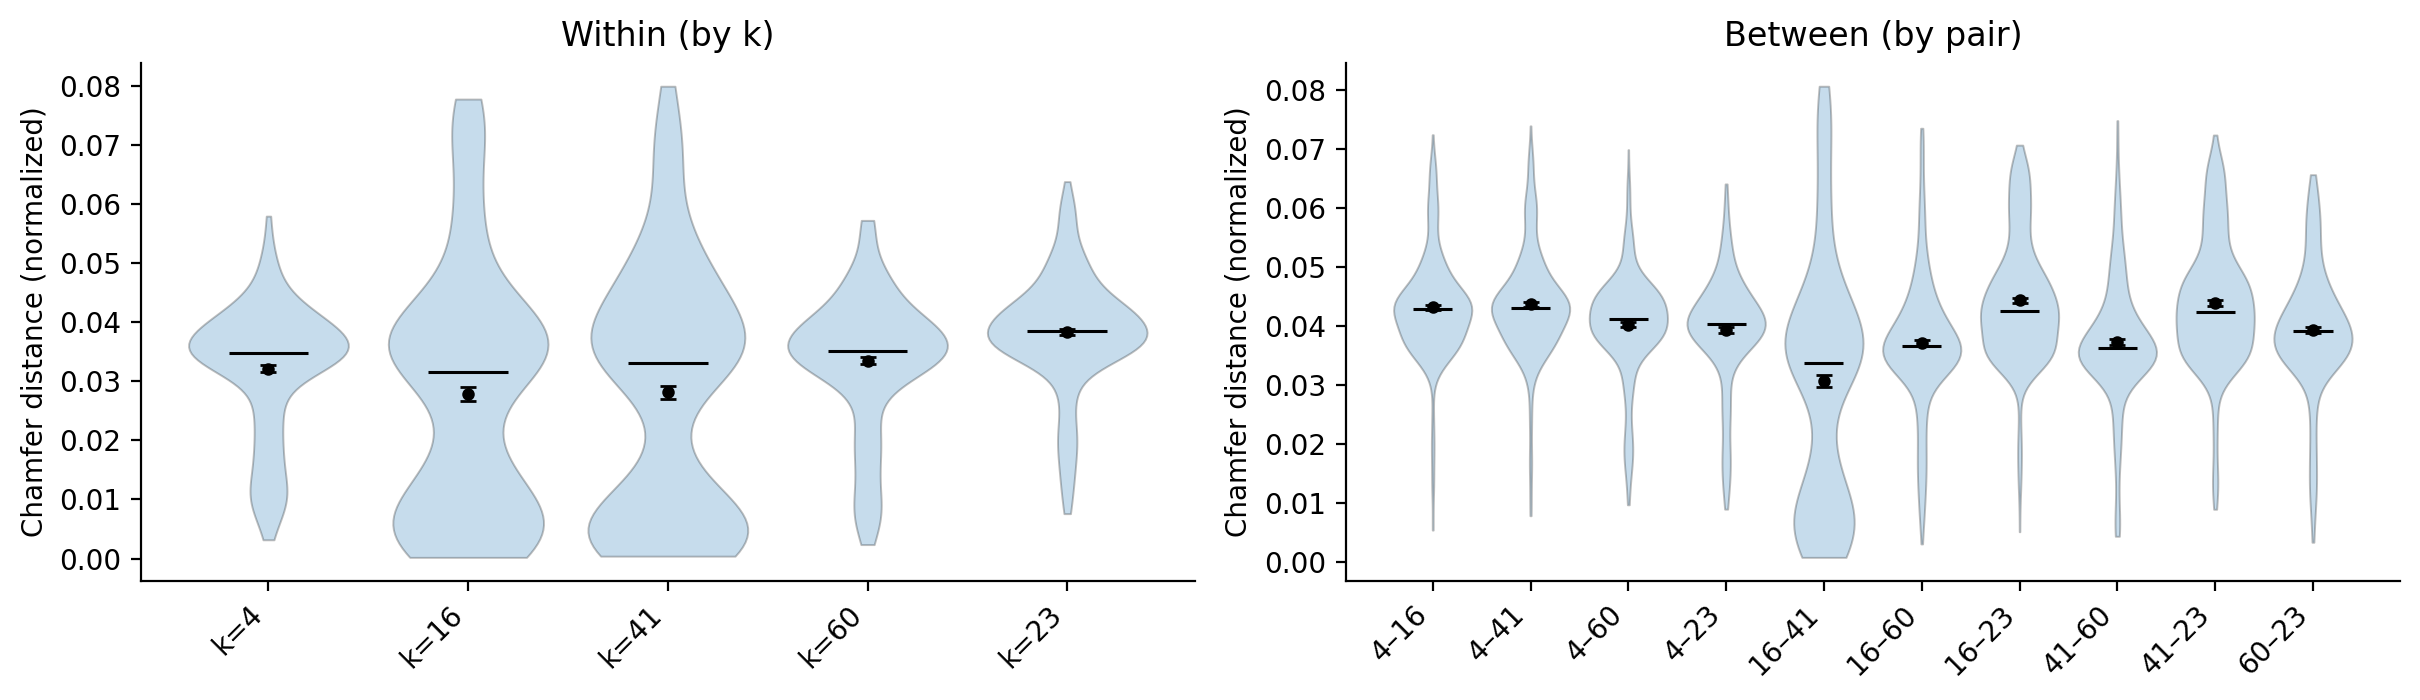

Saved: /home/hschatzle/monte-carlo-selection/results/chamfer_within_between_grouped.svg


In [20]:
# Cell: Grouped chamfer distributions
# - Within: one distribution per k
# - Between: one distribution per (k1,k2) pair
# Output: two clean figures (within-only + between-only), plus an optional combined figure.
#
# Requires:
#   ks (list of components), picked (dict k -> eligible indices j)
#   resp (nE,K) and/or Y to get nE
#   polygons (object array of contours)
# Optional:
#   E_idx (len nE) for eligible->global mapping
#   pixel_to_norm_refined_safe() for pixel->normalized mapping

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from itertools import combinations
from pathlib import Path

# ---------------- params ----------------
M_PER_CLUSTER = 50        # shapes sampled per component (controls speed + stability)
N_PTS = 220               # resample count per contour
MAX_WITHIN_PAIRS = 350    # cap per k
MAX_BETWEEN_PAIRS = 450   # cap per (k1,k2)
RNG_SEED = 0

# plotting
DPI = 200
OUT_WITHIN = Path("chamfer_within_by_k.svg")
OUT_BETWEEN = Path("chamfer_between_by_pair.svg")
OUT_COMBINED = Path("chamfer_within_between_grouped.svg")

rng = np.random.default_rng(RNG_SEED)

# ---------------- helpers ----------------
def j_to_global(j, nE):
    if "E_idx" in globals() and len(E_idx) == nE:
        return int(np.asarray(E_idx, dtype=int)[int(j)])
    return int(j)

def resample_closed_poly(xy, n_pts=220):
    xy = np.asarray(xy, dtype=np.float64)
    if xy.shape[0] < 5:
        return xy
    if np.linalg.norm(xy[0] - xy[-1]) > 1e-9:
        xy = np.vstack([xy, xy[0]])
    d = np.sqrt(np.sum(np.diff(xy, axis=0)**2, axis=1))
    s = np.r_[0.0, np.cumsum(d)]
    L = s[-1]
    if L < 1e-12:
        return xy[:1].repeat(n_pts, axis=0)
    t = np.linspace(0.0, L, n_pts, endpoint=False)
    x = np.interp(t, s, xy[:, 0])
    y = np.interp(t, s, xy[:, 1])
    return np.stack([x, y], axis=1)

def normalize_xy(xy):
    xy = np.asarray(xy, dtype=np.float64)
    c = xy.mean(axis=0)
    z = xy - c
    s = np.sqrt(np.mean(np.sum(z*z, axis=1))) + 1e-12
    return z / s

def to_xy_for_chamfer(global_i):
    poly_pix = np.asarray(polygons[int(global_i)], dtype=np.float64)
    if "pixel_to_norm_refined_safe" in globals():
        xy = pixel_to_norm_refined_safe(poly_pix)
    else:
        xy = poly_pix
    xy = resample_closed_poly(xy, n_pts=N_PTS)
    xy = normalize_xy(xy)
    return xy

def chamfer(xyA, xyB):
    A = np.asarray(xyA, dtype=np.float64)
    B = np.asarray(xyB, dtype=np.float64)
    nnB = NearestNeighbors(n_neighbors=1).fit(B)
    dA, _ = nnB.kneighbors(A, return_distance=True)
    nnA = NearestNeighbors(n_neighbors=1).fit(A)
    dB, _ = nnA.kneighbors(B, return_distance=True)
    return float(dA.mean() + dB.mean())

def sample(arr, m):
    arr = np.asarray(arr, dtype=int)
    if arr.size <= m:
        return arr
    return rng.choice(arr, size=m, replace=False)

def violin_clean(ax, data_list, labels, title):
    pos = np.arange(1, len(data_list)+1)
    vp = ax.violinplot(data_list, positions=pos, widths=0.8, showmeans=False, showmedians=True, showextrema=False)
    for body in vp["bodies"]:
        body.set_alpha(0.25)
        body.set_edgecolor("black")
        body.set_linewidth(0.7)
    vp["cmedians"].set_color("black")
    vp["cmedians"].set_linewidth(1.1)

    # mean±SEM overlay
    means = [float(np.mean(x)) if len(x) else np.nan for x in data_list]
    sems  = [float(np.std(x, ddof=1)/np.sqrt(max(1, len(x)))) if len(x) > 1 else np.nan for x in data_list]
    ax.errorbar(pos, means, yerr=sems, fmt="o", color="black", capsize=3, markersize=3.5, linewidth=1.0, zorder=5)

    ax.set_xticks(pos)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylabel("Chamfer distance (normalized)")
    ax.set_title(title)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    return ax

# ---------------- gather exemplars and cache shapes ----------------
nE = int(resp.shape[0]) if "resp" in globals() else int(Y.shape[0])

exemplars = {}
for k in ks:
    sel = np.asarray(picked[k], dtype=int)
    if sel.size == 0:
        exemplars[k] = np.array([], dtype=int)
        continue
    js = sample(sel, M_PER_CLUSTER)
    gs = np.array([j_to_global(j, nE) for j in js], dtype=int)
    exemplars[k] = gs

print("Exemplars per k:", {k: int(exemplars[k].size) for k in ks})

xy_cache = {}
for k in ks:
    for gi in exemplars[k]:
        if gi not in xy_cache:
            xy_cache[gi] = to_xy_for_chamfer(gi)

# ---------------- compute within by k ----------------
within_by_k = {}
for k in ks:
    g = exemplars[k]
    if g.size < 2:
        within_by_k[k] = np.array([], dtype=np.float64)
        continue
    pairs = list(combinations(g.tolist(), 2))
    if len(pairs) > MAX_WITHIN_PAIRS:
        pairs = rng.choice(pairs, size=MAX_WITHIN_PAIRS, replace=False).tolist()
    vals = [chamfer(xy_cache[a], xy_cache[b]) for a, b in pairs]
    within_by_k[k] = np.asarray(vals, dtype=np.float64)

# ---------------- compute between by pair ----------------
between_by_pair = {}
pair_list = list(combinations(ks, 2))
for k1, k2 in pair_list:
    g1, g2 = exemplars[k1], exemplars[k2]
    if g1.size == 0 or g2.size == 0:
        between_by_pair[(k1, k2)] = np.array([], dtype=np.float64)
        continue
    all_pairs = [(int(a), int(b)) for a in g1 for b in g2]
    if len(all_pairs) > MAX_BETWEEN_PAIRS:
        all_pairs = rng.choice(all_pairs, size=MAX_BETWEEN_PAIRS, replace=False).tolist()
    vals = [chamfer(xy_cache[a], xy_cache[b]) for a, b in all_pairs]
    between_by_pair[(k1, k2)] = np.asarray(vals, dtype=np.float64)

# ---------------- summarize ----------------
print("\n--- Within (by k) ---")
for k in ks:
    v = within_by_k[k]
    if v.size == 0:
        print(f"k={k}: n=0")
    else:
        print(f"k={k}: n={v.size} mean={float(v.mean()):.4g} median={float(np.median(v)):.4g}")

print("\n--- Between (by pair) ---")
for (k1, k2) in pair_list:
    v = between_by_pair[(k1, k2)]
    if v.size == 0:
        print(f"{k1}-{k2}: n=0")
    else:
        print(f"{k1}-{k2}: n={v.size} mean={float(v.mean()):.4g} median={float(np.median(v)):.4g}")

# ---------------- plot within-only ----------------
within_data = [within_by_k[k] for k in ks]
within_labels = [f"k={k}" for k in ks]

fig1, ax1 = plt.subplots(figsize=(6.0, 3.6), dpi=DPI)
violin_clean(ax1, within_data, within_labels, "Within-cluster chamfer (per component)")
plt.tight_layout()
fig1.savefig(OUT_WITHIN, format="svg", bbox_inches="tight", pad_inches=0.02)
plt.show()
print("Saved:", OUT_WITHIN.resolve())

# ---------------- plot between-only ----------------
between_data = [between_by_pair[p] for p in pair_list]
between_labels = [f"{p[0]}–{p[1]}" for p in pair_list]

fig2, ax2 = plt.subplots(figsize=(9.0, 3.6), dpi=DPI)
violin_clean(ax2, between_data, between_labels, "Between-cluster chamfer (per component pair)")
plt.tight_layout()
fig2.savefig(OUT_BETWEEN, format="svg", bbox_inches="tight", pad_inches=0.02)
plt.show()
print("Saved:", OUT_BETWEEN.resolve())

# ---------------- optional: combined figure (within left, between right) ----------------
fig3, (axL, axR) = plt.subplots(1, 2, figsize=(12.2, 3.6), dpi=DPI)
violin_clean(axL, within_data, within_labels, "Within (by k)")
violin_clean(axR, between_data, between_labels, "Between (by pair)")
plt.tight_layout()
fig3.savefig(OUT_COMBINED, format="svg", bbox_inches="tight", pad_inches=0.02)
plt.show()
print("Saved:", OUT_COMBINED.resolve())


In [32]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(within, between, alternative="less")
print("Mann–Whitney U p-value:", p)


Mann–Whitney U p-value: 2.066267678210434e-73


Mean within: 0.03321557570094018
Mean between: 0.04000345916057736
Between/Within ratio: 1.2043584467947384


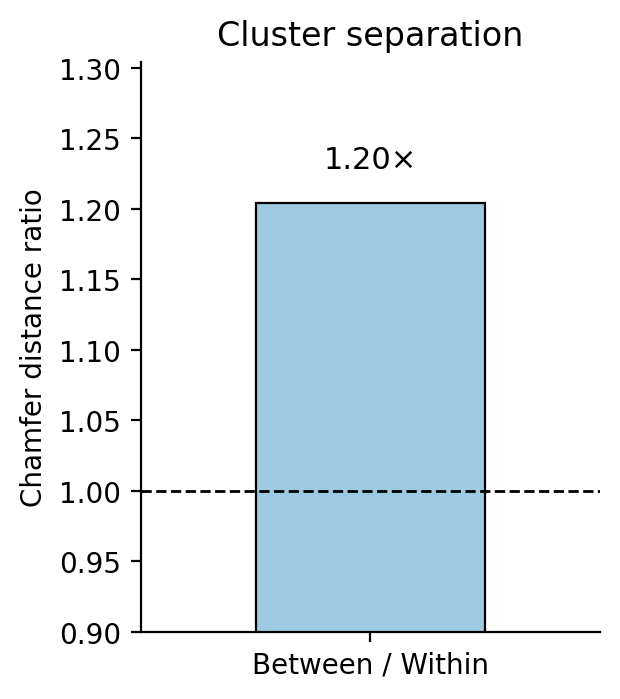

Exported: /home/hschatzle/monte-carlo-selection/notebooks/chamfer_ratio_bar.svg


In [33]:
# Ratio bar plot: between-cluster vs within-cluster chamfer
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

within = np.asarray(within, dtype=np.float64)
between = np.asarray(between, dtype=np.float64)

OUT = Path("chamfer_ratio_bar.svg")

# compute ratio
mean_within = float(np.mean(within))
mean_between = float(np.mean(between))
ratio = mean_between / mean_within

print("Mean within:", mean_within)
print("Mean between:", mean_between)
print("Between/Within ratio:", ratio)

# ---- plot ----
fig, ax = plt.subplots(figsize=(3.2, 3.6), dpi=200)

bar = ax.bar(
    [1],
    [ratio],
    width=0.6,
    color="#9ecae1",
    edgecolor="black",
    linewidth=0.8
)

# reference line at no separation
ax.axhline(1.0, color="black", linewidth=1.0, linestyle="--")

# annotate ratio
ax.text(
    1,
    ratio + 0.02,
    f"{ratio:.2f}×",
    ha="center",
    va="bottom",
    fontsize=11
)

ax.set_xlim(0.4, 1.6)
ax.set_ylim(0.9, max(1.25, ratio + 0.1))

ax.set_xticks([1])
ax.set_xticklabels(["Between / Within"])

ax.set_ylabel("Chamfer distance ratio")
ax.set_title("Cluster separation")

# clean axes
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
fig.savefig(OUT, format="svg", bbox_inches="tight", pad_inches=0.02)
plt.show()

print("Exported:", OUT.resolve())


Exemplars per k: {4: 180, 16: 180, 41: 180, 60: 180, 23: 180}
Within distances:  n=1250 (pairs sampled total=1250)  mean=0.03285
Between distances: n=2250 (pairs sampled total=2250) mean=0.04038


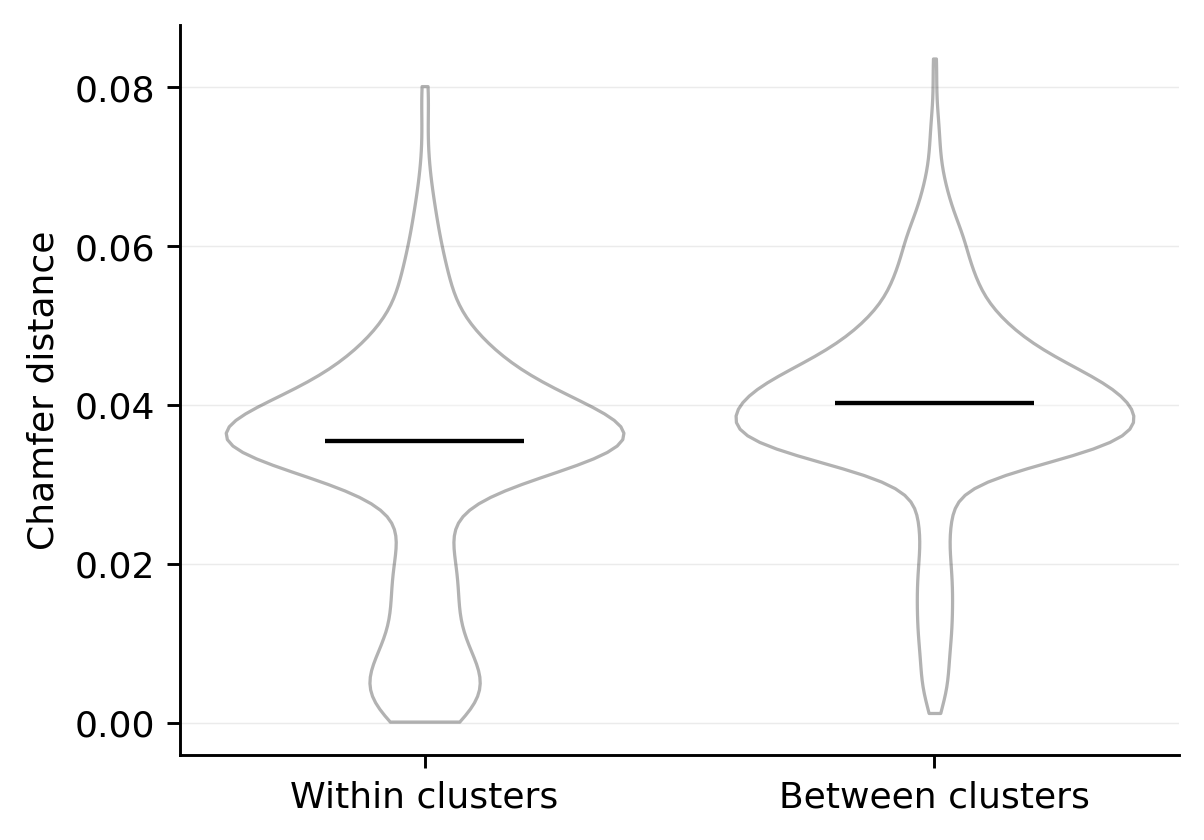

Exported: /home/hschatzle/monte-carlo-selection/results/chamfer_within_between_violin.ai_clean.svg
Exported: /home/hschatzle/monte-carlo-selection/results/chamfer_within_between_violin.ai_clean.pdf


In [25]:
# Cell 1 — Option 1. Paired within–between violin (or box) plot.
# Strongest story: directly compare the distributions of within vs between Chamfer distances.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from itertools import combinations
from pathlib import Path

# ---------------- params ----------------
M_PER_CLUSTER = 250
N_PTS = 220
MAX_WITHIN_PAIRS = 250
MAX_BETWEEN_PAIRS = 450
RNG_SEED = 0

PLOT_KIND = "violin"   # "violin" or "box"
OUT = Path("chamfer_within_between_violin.svg")
DPI = 260

rng = np.random.default_rng(RNG_SEED)

# ---------------- helpers ----------------
nE = int(resp.shape[0]) if "resp" in globals() else int(Y.shape[0])

def j_to_global(j):
    if "E_idx" in globals() and len(E_idx) == nE:
        return int(np.asarray(E_idx, dtype=int)[int(j)])
    return int(j)

def resample_closed_poly(xy, n_pts=220):
    xy = np.asarray(xy, dtype=np.float64)
    if xy.shape[0] < 5:
        return xy
    if np.linalg.norm(xy[0] - xy[-1]) > 1e-9:
        xy = np.vstack([xy, xy[0]])
    d = np.sqrt(np.sum(np.diff(xy, axis=0) ** 2, axis=1))
    s = np.r_[0.0, np.cumsum(d)]
    L = s[-1]
    if L < 1e-12:
        return xy[:1].repeat(n_pts, axis=0)
    t = np.linspace(0.0, L, n_pts, endpoint=False)
    x = np.interp(t, s, xy[:, 0])
    y = np.interp(t, s, xy[:, 1])
    return np.stack([x, y], axis=1)

def normalize_xy(xy):
    xy = np.asarray(xy, dtype=np.float64)
    c = xy.mean(axis=0)
    z = xy - c
    s = np.sqrt(np.mean(np.sum(z * z, axis=1))) + 1e-12
    return z / s

def to_xy(global_i):
    poly_pix = np.asarray(polygons[int(global_i)], dtype=np.float64)
    if "pixel_to_norm_refined_safe" in globals():
        xy = pixel_to_norm_refined_safe(poly_pix)
    else:
        xy = poly_pix
    xy = resample_closed_poly(xy, n_pts=N_PTS)
    xy = normalize_xy(xy)
    return xy

def chamfer(xyA, xyB):
    A = np.asarray(xyA, dtype=np.float64)
    B = np.asarray(xyB, dtype=np.float64)
    nnB = NearestNeighbors(n_neighbors=1).fit(B)
    dA, _ = nnB.kneighbors(A, return_distance=True)
    nnA = NearestNeighbors(n_neighbors=1).fit(A)
    dB, _ = nnA.kneighbors(B, return_distance=True)
    return float(dA.mean() + dB.mean())

def sample(arr, m):
    arr = np.asarray(arr, dtype=int)
    if arr.size <= m:
        return arr
    return rng.choice(arr, size=m, replace=False)

# ---------------- choose exemplars per cluster ----------------
exemplars = {}
for k in ks:
    sel = np.asarray(picked[k], dtype=int)
    if sel.size == 0:
        exemplars[k] = np.array([], dtype=int)
        continue
    js = sample(sel, M_PER_CLUSTER)
    exemplars[k] = np.array([j_to_global(j) for j in js], dtype=int)

print("Exemplars per k:", {k: int(exemplars[k].size) for k in ks})

# cache XY for speed
xy_cache = {}
for k in ks:
    for gi in exemplars[k]:
        if gi not in xy_cache:
            xy_cache[gi] = to_xy(gi)

# ---------------- collect pooled within/between distances ----------------
within_vals = []
between_vals = []

within_pairs_total = 0
between_pairs_total = 0

for k in ks:
    gk = exemplars[k]
    if gk.size >= 2:
        pairs = list(combinations(gk.tolist(), 2))
        if len(pairs) > MAX_WITHIN_PAIRS:
            pairs = rng.choice(pairs, size=MAX_WITHIN_PAIRS, replace=False).tolist()
        within_vals.extend([chamfer(xy_cache[a], xy_cache[b]) for a, b in pairs])
        within_pairs_total += len(pairs)

    others = np.concatenate([exemplars[kk] for kk in ks if kk != k]) if len(ks) > 1 else np.array([], dtype=int)
    if gk.size > 0 and others.size > 0:
        all_pairs = [(int(a), int(b)) for a in gk for b in others]
        if len(all_pairs) > MAX_BETWEEN_PAIRS:
            all_pairs = rng.choice(all_pairs, size=MAX_BETWEEN_PAIRS, replace=False).tolist()
        between_vals.extend([chamfer(xy_cache[a], xy_cache[b]) for a, b in all_pairs])
        between_pairs_total += len(all_pairs)

within_vals = np.asarray(within_vals, dtype=np.float64)
between_vals = np.asarray(between_vals, dtype=np.float64)

print(f"Within distances:  n={within_vals.size} (pairs sampled total={within_pairs_total})  mean={within_vals.mean():.5f}")
print(f"Between distances: n={between_vals.size} (pairs sampled total={between_pairs_total}) mean={between_vals.mean():.5f}")

# ---------------- plot (Illustrator-clean) ----------------
import matplotlib as mpl
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"],
    "svg.fonttype": "none",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(4.6, 3.2), dpi=DPI, facecolor="white")
ax.set_facecolor("white")

data = [within_vals, between_vals]
labels = ["Within clusters", "Between clusters"]

if PLOT_KIND.lower() == "violin":
    vp = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=False, widths=0.78)
    # Minimal styling: no alpha, clean strokes
    for body in vp["bodies"]:
        body.set_edgecolor("black")
        body.set_linewidth(0.9)
        body.set_facecolor("white")
    vp["cmedians"].set_color("black")
    vp["cmedians"].set_linewidth(1.2)

elif PLOT_KIND.lower() == "box":
    bp = ax.boxplot(data, widths=0.58, patch_artist=True, showfliers=False)
    for patch in bp["boxes"]:
        patch.set(facecolor="white", edgecolor="black", linewidth=0.9)
    for key in ["whiskers", "caps", "medians"]:
        for item in bp[key]:
            item.set(color="black", linewidth=1.0)

else:
    raise ValueError("PLOT_KIND must be 'violin' or 'box'.")

ax.set_xticks([1, 2])
ax.set_xticklabels(labels, fontsize=10)
ax.set_ylabel("Chamfer distance", fontsize=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# light y-grid can be helpful, but keep minimal
ax.grid(axis="y", linewidth=0.4, alpha=0.25)
ax.set_axisbelow(True)

plt.tight_layout(pad=0.6)

OUT_SVG = Path("chamfer_within_between_violin.ai_clean.svg")
OUT_PDF = Path("chamfer_within_between_violin.ai_clean.pdf")
fig.savefig(OUT_SVG, format="svg", bbox_inches="tight", pad_inches=0.08, facecolor="white")
fig.savefig(OUT_PDF, format="pdf", bbox_inches="tight", pad_inches=0.08, facecolor="white")

plt.show()
print("Exported:", OUT_SVG.resolve())
print("Exported:", OUT_PDF.resolve())


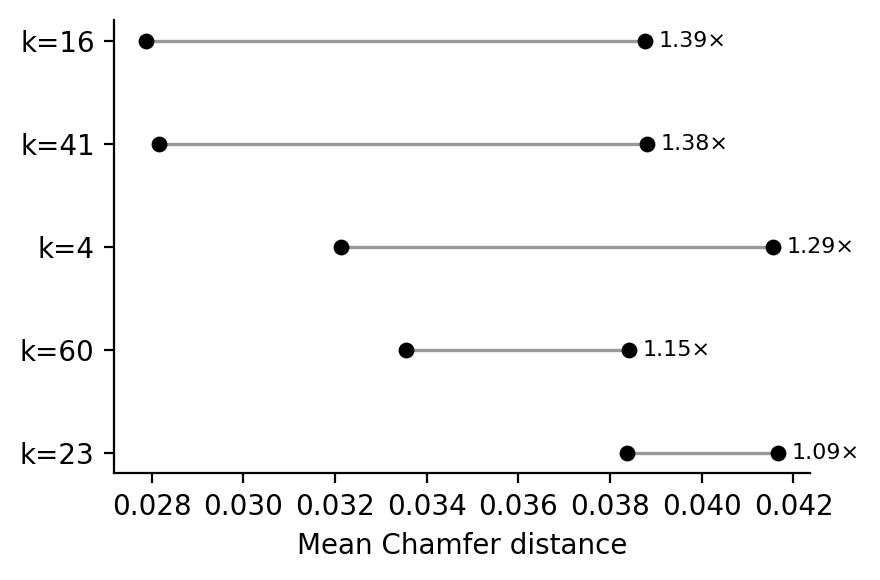

In [27]:
# ... rows_sorted already computed ...

fig, ax = plt.subplots(figsize=(4.5, 3.0), dpi=200)

y = np.arange(len(rows_sorted))

for i, r in enumerate(rows_sorted):
    w = r["within"]
    b = r["between"]
    ratio = r["ratio"]

    ax.plot([w, b], [y[i], y[i]], color="0.6", linewidth=1.2, zorder=1)
    ax.scatter(w, y[i], color="black", s=22, zorder=2)
    ax.scatter(b, y[i], color="black", s=22, zorder=2)
    ax.text(b + 0.0003, y[i], f"{ratio:.2f}×", va="center", fontsize=8)

ax.set_yticks(y)
ax.set_yticklabels([f"k={r['k']}" for r in rows_sorted])
ax.set_xlabel("Mean Chamfer distance")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.invert_yaxis()  # <- THIS fixes the visual order

plt.tight_layout()
plt.savefig("panel_d_sorted_slope.svg", bbox_inches="tight")
plt.show()


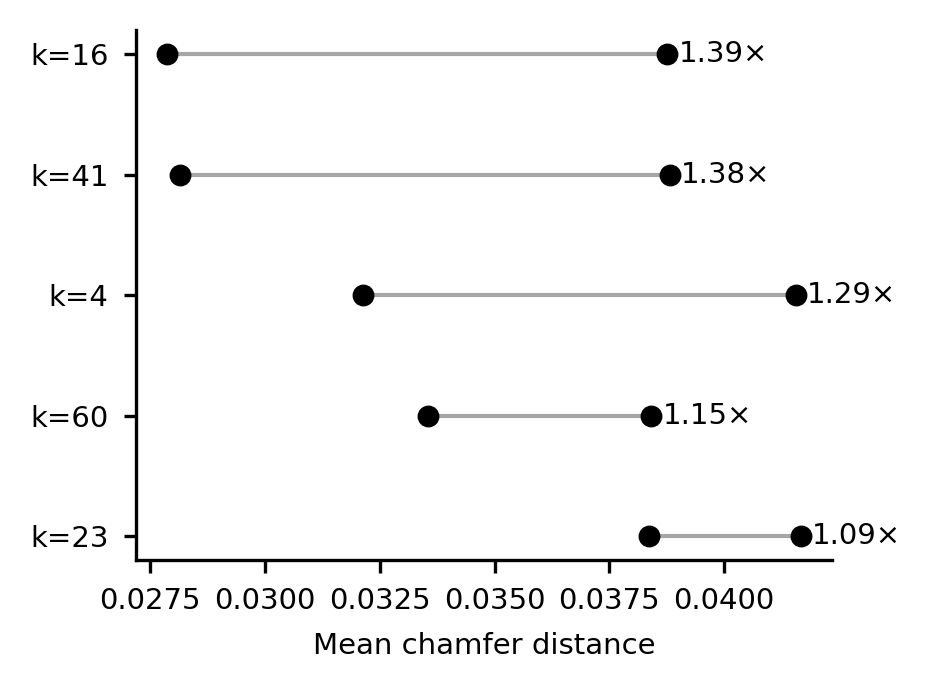

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# rows_sorted already computed

fig, ax = plt.subplots(figsize=(3.2, 2.4), dpi=300)

y = np.arange(len(rows_sorted))

for i, r in enumerate(rows_sorted):
    w = r["within"]
    b = r["between"]
    ratio = r["ratio"]

    # thin connector
    ax.plot([w, b], [y[i], y[i]],
            color="0.65",
            linewidth=1.0,
            zorder=1)

    # endpoints
    ax.scatter(w, y[i], color="black", s=18, zorder=2)
    ax.scatter(b, y[i], color="black", s=18, zorder=2)

    # ratio label
    ax.text(b + 0.00025, y[i],
            f"{ratio:.2f}×",
            va="center",
            fontsize=7)

# axis labels
ax.set_yticks(y)
ax.set_yticklabels([f"k={r['k']}" for r in rows_sorted], fontsize=7)
ax.set_xlabel("Mean chamfer distance", fontsize=7)

# spine styling
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.8)
ax.spines["bottom"].set_linewidth(0.8)

ax.tick_params(axis='x', labelsize=7, width=0.8, length=3)
ax.tick_params(axis='y', labelsize=7, width=0.8, length=3)

ax.invert_yaxis()

plt.tight_layout()
plt.savefig("panel_d_nature_style.svg", bbox_inches="tight")
plt.show()
